# Latent Dirichlet Allocation models on BBC data

### Model 1. Scikit-learn

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import textwrap
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import string
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import PorterStemmer
import spacy
import gensim
import gensim.corpora as corpora
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pickle
import pyLDAvis
import os
from gensim.models import CoherenceModel, TfidfModel
import pyLDAvis.gensim
import re
from bertopic import BERTopic
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MeanShift, Birch
from sentence_transformers import SentenceTransformer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from skopt.space import Real, Integer
from sklearn.mixture import GaussianMixture


stops = stopwords.words('english')
stops.extend(['has', 'been', 're', 'com', 'edu', 'use', 'said', 'would', 'could', 'told', 'also', 'one', 'two', 'mr', 'new', 'year', 'people'])

In [2]:
# Read the data
df = pd.read_csv('bbc_text_cls.csv')

# Remove missing values
df.dropna(axis = 0, how ='any', inplace=True)

# # Add num words column
# df['Num_words_text'] = df['text'].apply(lambda x:len(str(x).split()))
# max_review_data_sentence_length  = df['Num_words_text'].max()

# # Create a mask to filter out long reviews and very short ones
# mask = (df['Num_words_text'] < 100) & (df['Num_words_text'] >=20)
# df = df[mask]

# Remove punctuation
def remove_punctuation(text):
  return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punctuation)

# Remove \n characters
df['text'] = df['text'].str.replace('\n', ' ')

# Remove digits and non-alphanumeric characters
df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')

# Lowercase the text
df['text'] = df['text'].str.lower()

# Normalize whitespace
def normalize_whitespace(text):
    text = re.sub('[\s]+', ' ', text)
    return text

df['text'] = df['text'].map(normalize_whitespace)

# Remove stopwords
def remove_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stops])
    return text

df['text'] = df['text'].apply(remove_stopwords)

# Lemmatization
def lemmatization(text, allowed_postags = ['NOUN', 'ADJ']):
  doc = nlp(''.join(text))
  doc = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
  return ' '.join(doc)

nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
df['text'] = df['text'].map(lemmatization)

# Stemming
def stemming(text):
  doc = [PorterStemmer().stem(w).strip() for w in text.split()]
  return ' '.join(doc)

df['text'] = df['text'].map(stemming)

# # Remove words that contain digits - CONSIDER USING THIS ONE VERY CAREFULLY! PROVIDES WORSE RESULTS IN THIS CASE!
# pattern = re.compile(r'\b\w*\d\w*\b')
# df['text'] = df['text'].apply(lambda x: pattern.sub('', x))

# # Remove short words
# def short_words_removal(text):
#   text = text.split()
#   text = [word for word in text if len(word) > 2]
#   text = ' '.join(text)
#   return text

# df['text'] = df['text'].map(short_words_removal)

# Normalize whitespace again
df['text'] = df['text'].map(normalize_whitespace)

<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
<>:25: DeprecationWarning: invalid escape sequence \s
<>:32: DeprecationWarning: invalid escape sequence \s
C:\Users\User\AppData\Local\Temp\ipykernel_23108\1324980053.py:25: DeprecationWarning: invalid escape sequence \s
  df['text'] = df['text'].str.replace('[^a-zA-Z0-9\s]', '')
C:\Users\User\AppData\Local\Temp\ipykernel_23108\1324980053.py:32: DeprecationWarning: invalid escape sequence \s
  text = re.sub('[\s]+', ' ', text)


In [42]:
# Auxillary preproccessing function for new texts: NEED AN UPDATE
# def preprocess(texts):
#   texts = [text.translate(str.maketrans('', '', string.punctuation)) for text in texts]
#   texts = [text.replace('\n', ' ') for text in texts]
#   texts = [text.replace('[^a-zA-Z0-9\s]', '') for text in texts]
#   texts = [text.lower() for text in texts]
#   texts = [re.sub('[\s]+', ' ', text) for text in texts]
#   texts = [" ".join([word for word in text.split() if word not in stops]) for text in texts]
  
#   nlp = spacy.load('en_core_web_sm', disable = ['parser', 'ner'])
#   allowed_postags = ['NOUN', 'ADJ', 'ADV', 'VERB']
#   texts = [nlp(''.join(text)) for text in texts]
#   texts = [[token.lemma_ for token in text if token.pos_ in allowed_postags] for text in texts]
#   texts = [' '.join(text) for text in texts]
  
#   texts = [' '.join([PorterStemmer().stem(w).strip() for w in text.split()]) for text in texts]
#   texts = [text.split() for text in texts]
#   texts = [[word for word in text if len(word) > 2] for text in texts]
#   texts = [' '.join(text) for text in texts]
  
#   texts = [re.sub('[\s]+', ' ', text) for text in texts]
#   texts = [text.strip() for text in texts]
#   return texts

In [43]:
df['labels'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: labels, dtype: int64

In [44]:
# Create count vectorizer
vectorizer = CountVectorizer(stop_words = list(stops),
                            # min_df = 20,
                            # max_df = 0.2,
                            # max_features = 5000,
#                             ngram_range = (1,3)
                            )
X = vectorizer.fit_transform(df['text'])

# Create an LDA model
num_topics = 5
lda = LatentDirichletAllocation(n_components = num_topics, random_state = 12345, max_iter = 100)
lda.fit(X)

LatentDirichletAllocation(max_iter=100, n_components=5, random_state=12345)

In [7]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()

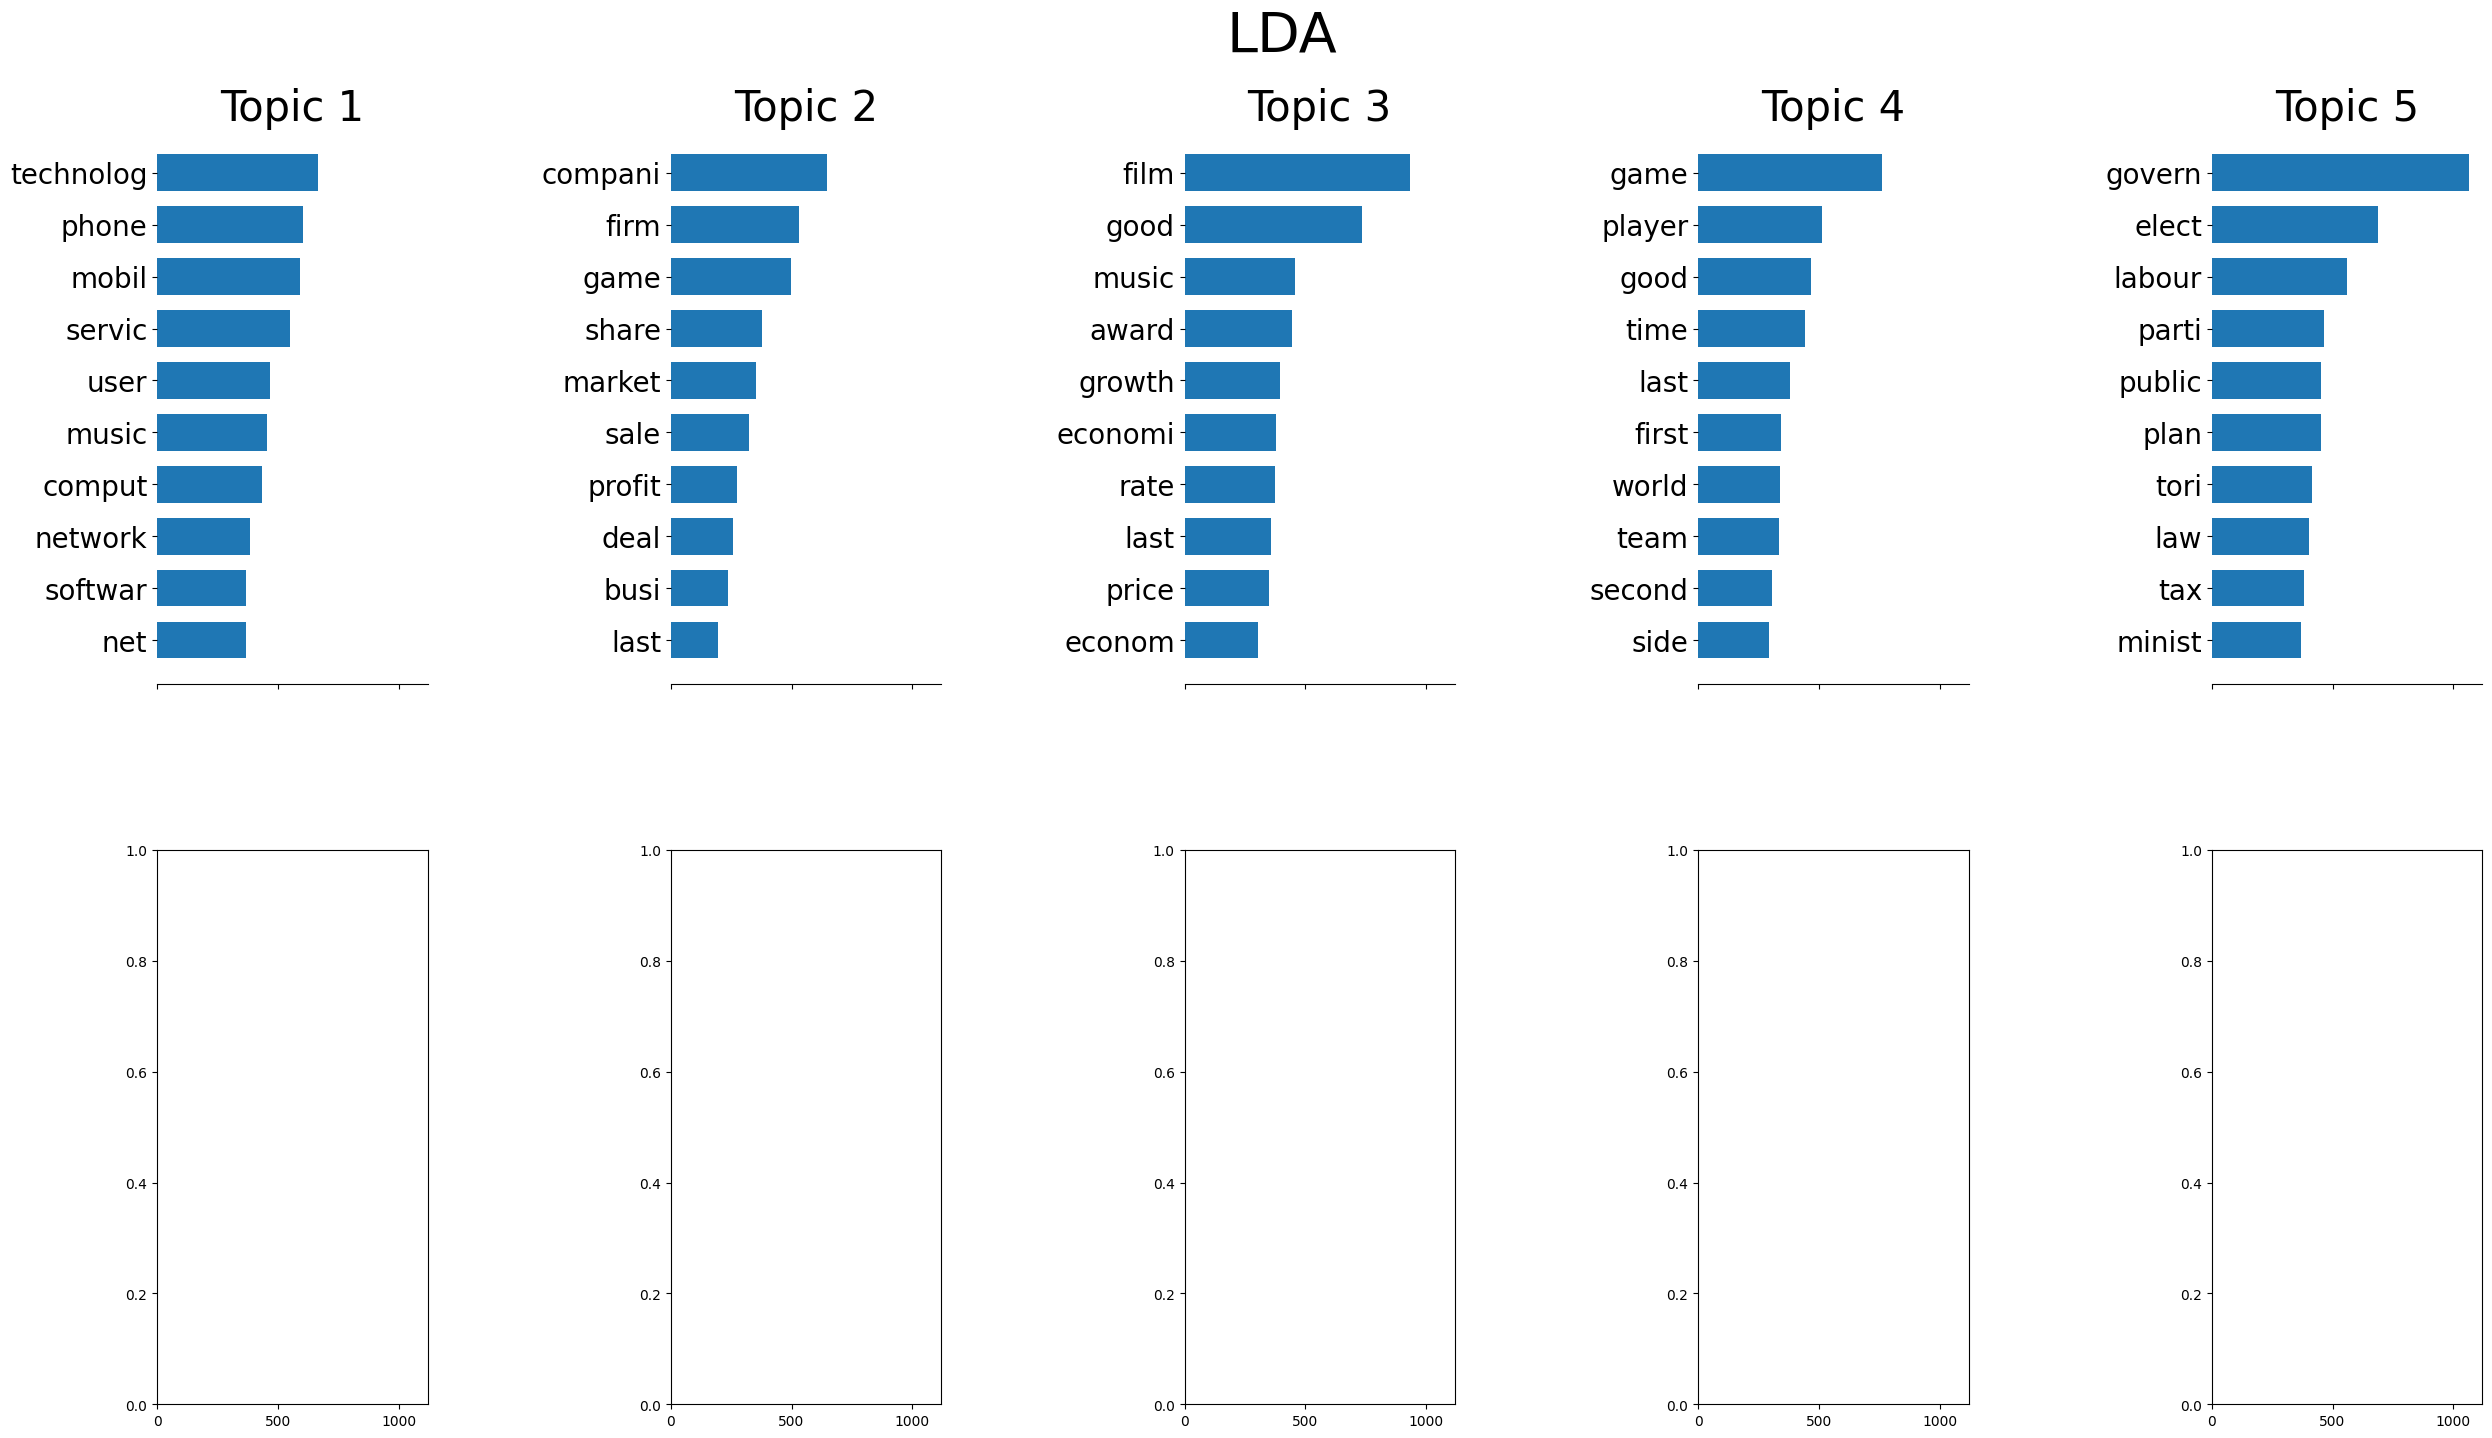

In [46]:
# Words per topics
feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda, feature_names)

# topic_vocab = {0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'business', 4: 'sport'}

In [47]:
# Sample code for model performance evaluation
new_sentences = vectorizer.transform(df['text'])
topic_distributions = lda.transform(new_sentences)
most_probable_topics = topic_distributions.argmax(axis=1)
topic_vocab = {0: 'tech', 1: 'business', 2: 'entertainment', 3: 'sport', 4: 'politics'}

preds = [topic_vocab[num_topic] for num_topic in most_probable_topics]

df['preds'] = preds


counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1
    
print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.8049438202247191


In [48]:
# Latent variables extraction
Z = lda.transform(X)

Text(0.5, 1.0, 'True label: sport')

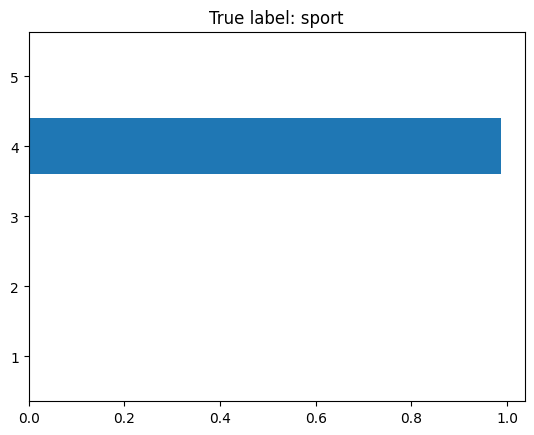

In [49]:
# Sample topic
np.random.seed(0)

i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(num_topics) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [50]:
# # Associated article
# def wrap(x):
#   return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

# print(wrap(df.iloc[i]['text']))

Text(0.5, 1.0, 'True label: entertainment')

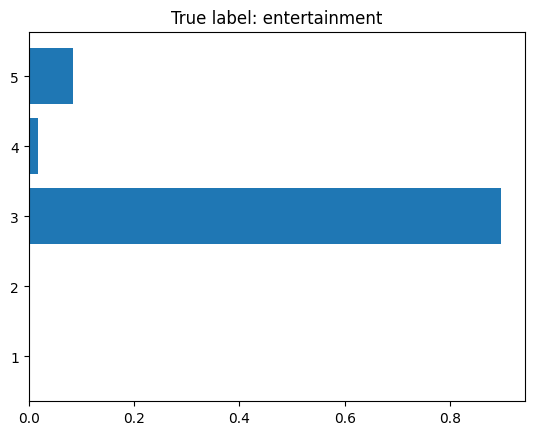

In [51]:
# Sample topic n2
i = np.random.choice(len(df))
z = Z[i]

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title('True label: %s' % df.iloc[i]['labels'])

In [52]:
# # Associated article n2
# print(wrap(df.iloc[i]['text']))

In [53]:
# Calculating the coherence and perplexity scores
vocab = vectorizer.get_feature_names_out()
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
id2word = corpora.Dictionary(words)

# Remove words shorter than 3
words_new = []
for word_list in words:
  x = [word for word in word_list if len(word) > 3]
  words_new.append(x)
words = words_new



topics = []
for i in range(lda.n_components):
    topic_words = [vocab[j] for j in lda.components_[i].argsort()[:-10 - 1:-1]]
    topics.append(topic_words)


coherence_model_lda = CoherenceModel(topics=topics, texts=words, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
perplexity = np.log(lda.perplexity(X))
log_likelihood = lda.score(X)
print(f'The coherence score is: {round(coherence_lda, 3)}')
print(f'The log perplexity score is: {round(perplexity, 3)}')
print(f'The log likelihood is: {round(log_likelihood, 3)}')

The coherence score is: 0.573
The log perplexity score is: 7.653
The log likelihood is: -1866813.204


In [55]:
def compute_coherence_values(dictionary, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    log_likelihood_scores = []
    
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100,
#                                          learning_method='online'
                                         )
        model.fit(X) 
        model_list.append(model)
        
        topics = []
        for i in range(model.n_components):
            topic_words = [vocab[j] for j in model.components_[i].argsort()[:-10 - 1:-1]]
            topics.append(topic_words)
        coherencemodel = CoherenceModel(topics=topics, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = np.log(model.perplexity(X))
        perplexity_list.append(perplexity)
        
        log_likelihood = model.score(X)
        log_likelihood_scores.append(log_likelihood)

    return model_list, coherence_values, perplexity_list, log_likelihood_scores
  
model_list, coherence_values, perplexity_list, log_likelihood_scores = compute_coherence_values(dictionary=id2word, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Log-likelihood Score')

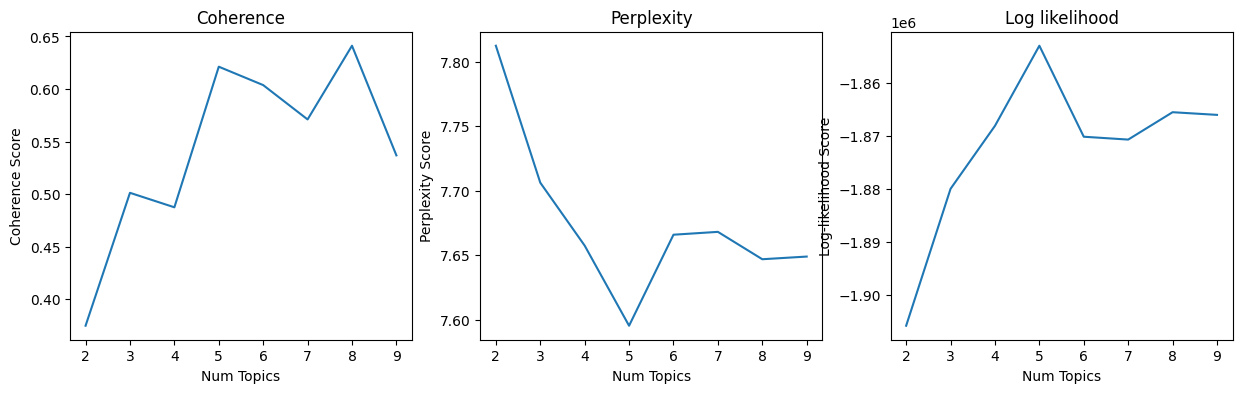

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

axs[2].plot(x, log_likelihood_scores)
axs[2].set_title('Log likelihood')
axs[2].set_xlabel('Num Topics')
axs[2].set_ylabel('Log-likelihood Score')

### Model 1.1 Sklearn LDA with Tfidf vectorizer.

In [57]:
# Tokenization and 

vectorizer_tf = TfidfVectorizer(stop_words = list(stops), 
                                max_df = 0.8, min_df = 2, 
                                use_idf = False, norm = None)
tf_vectors = vectorizer_tf.fit_transform(df['text'])

In [58]:
# LDA model definition
lda = LatentDirichletAllocation(n_components = 5, max_iter = 100, learning_method = 'batch', learning_offset = 50, n_jobs = -1, random_state = 111)

W1 = lda.fit_transform(tf_vectors)
H1 = lda.components_

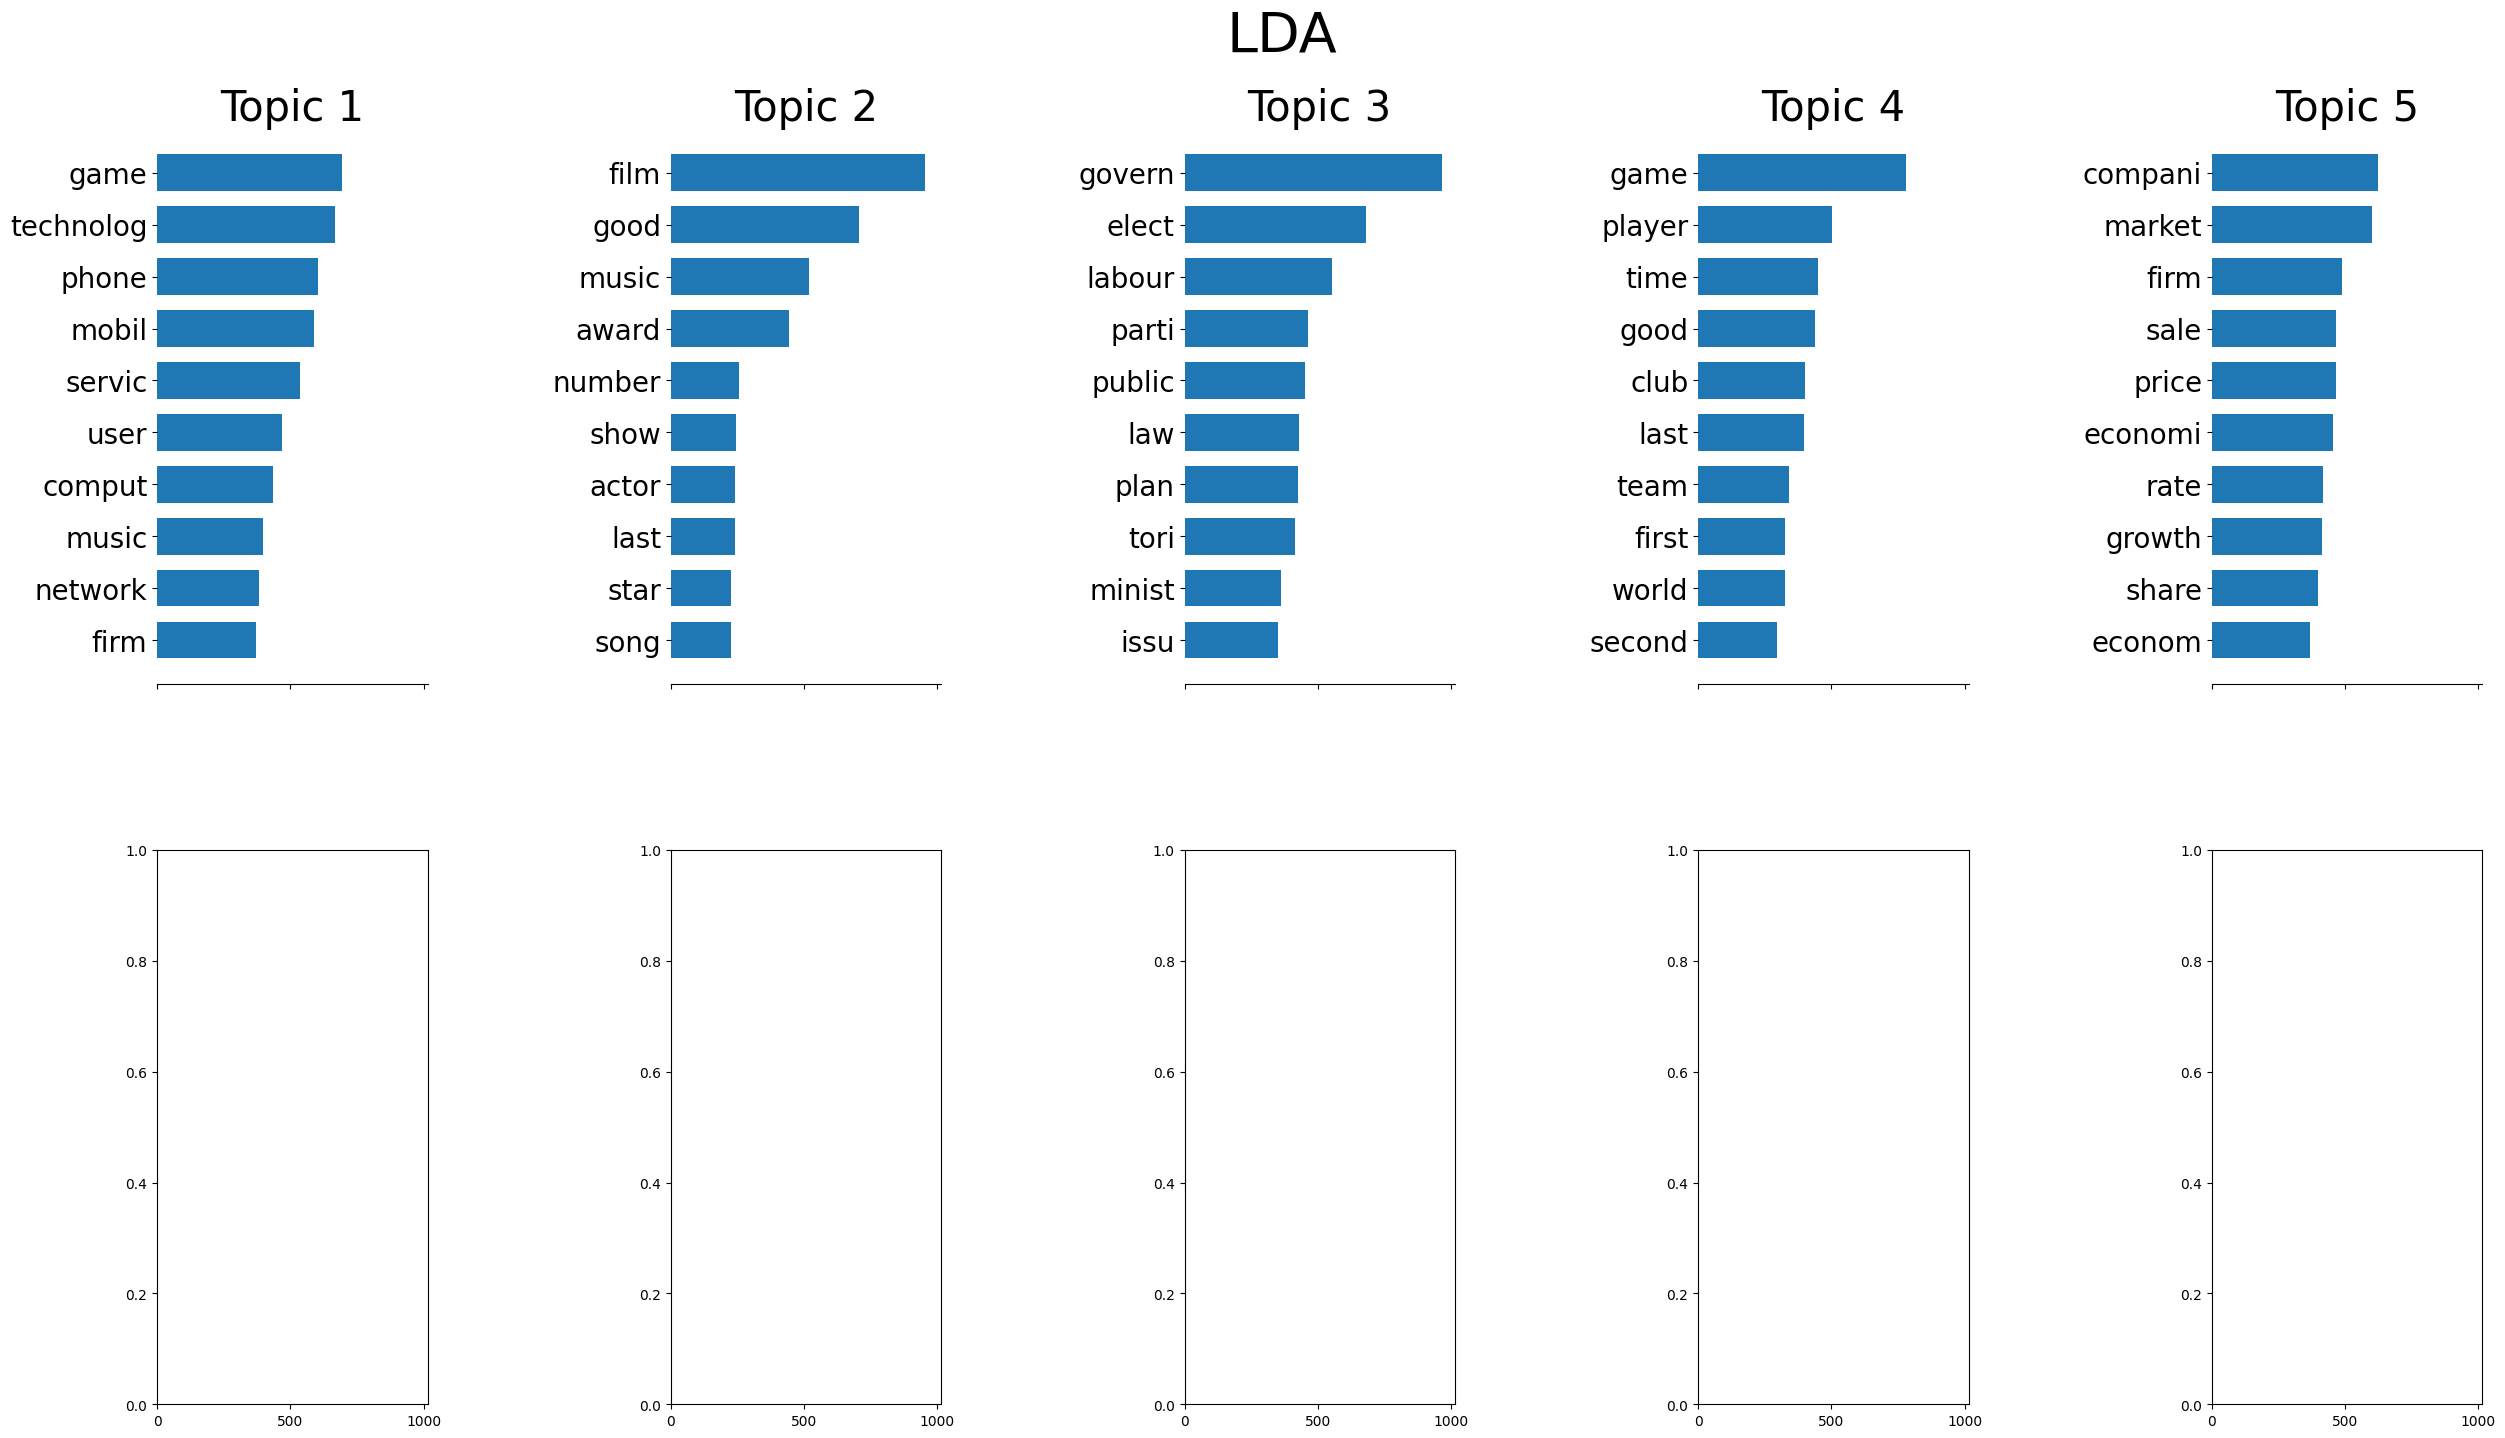

In [59]:
# Auxillary plotting function
def plot_top_words(model, feature_names, n_top_words = 10):
  fig, axes = plt.subplots(2, 5, figsize = (30, 15), sharex = True)
  axes = axes.flatten()
  for topic_idx, topic in enumerate(model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]
    
    ax = axes[topic_idx]
    ax.barh(top_features, weights, height = 0.7)
    ax.set_title(f'Topic {topic_idx + 1}', fontdict = {'fontsize': 30})
    ax.invert_yaxis()
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
    for i in 'top right left'.split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize = 40)
  
  plt.subplots_adjust(top = 0.90, bottom = 0.05, wspace = 0.90, hspace = 0.3)
  plt.show()
  
# Words per topics
feature_names = vectorizer_tf.get_feature_names_out()
plot_top_words(lda, feature_names)

In [60]:
# Sample code for model performance evaluation
new_sentences = vectorizer_tf.transform(df['text'])
topic_distributions = lda.transform(new_sentences)
most_probable_topics = topic_distributions.argmax(axis=1)
topic_vocab = {0: 'tech', 1: 'entertainmen', 2: 'politics', 3: 'sport', 4: 'business'}

preds = [topic_vocab[num_topic] for num_topic in most_probable_topics]

df['preds'] = preds

counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1
    
print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.7424719101123596


In [61]:
# Words per topic
num_words = 15

vocab = np.array(vectorizer_tf.get_feature_names_out())

top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]
topics

['game technolog phone mobil servic user comput music network firm softwar net mani digit system',
 'film good music award number show actor last star song top band director time first',
 'govern elect labour parti public law plan tori minist issu polit case campaign right leader',
 'game player time good club last team first world second side match final minut season',
 'compani market firm sale price economi rate growth share econom month busi last high bank']

In [62]:
# Topic per document probability distribution
colnames = ['Topic' + str(i) for i in range(lda.n_components)]
docnames = ['Doc' + str(i) for i in range(len(df['text']))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns = colnames, index = docnames)
df_doc_topic['dominant_topic'] = np.argmax(df_doc_topic.values, axis = 1)
df_doc_topic

Topic0  Topic1  Topic2  Topic3  Topic4  dominant_topic
Doc0       0.19    0.06    0.00    0.00    0.75               4
Doc1       0.02    0.00    0.00    0.00    0.97               4
Doc2       0.00    0.00    0.56    0.00    0.43               2
Doc3       0.00    0.00    0.09    0.04    0.87               4
Doc4       0.00    0.00    0.09    0.00    0.90               4
...         ...     ...     ...     ...     ...             ...
Doc2220    0.87    0.00    0.08    0.00    0.05               0
Doc2221    0.99    0.00    0.00    0.00    0.00               0
Doc2222    0.54    0.00    0.41    0.00    0.04               0
Doc2223    0.81    0.00    0.15    0.00    0.04               0
Doc2224    0.30    0.18    0.08    0.44    0.00               3

[2225 rows x 6 columns]

In [63]:
vocab = vectorizer_tf.get_feature_names_out()
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
# Remove words shorter than 3
words_new = []
for word_list in words:
  x = [word for word in word_list if len(word) > 3]
  words_new.append(x)
words = words_new

id2word = corpora.Dictionary(words)


def compute_coherence_values(dictionary, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    log_likelihood_scores = []
    
    for num_topics in range(start, limit, step):
        model = LatentDirichletAllocation(n_components = num_topics, max_iter = 100)
        model.fit(tf_vectors) 
        model_list.append(model)
        
        topics = []
        for i in range(model.n_components):
            topic_words = [vocab[j] for j in model.components_[i].argsort()[:-10 - 1:-1]]
            topics.append(topic_words)
            
        coherencemodel = CoherenceModel(topics=topics, texts=words, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = np.log(model.perplexity(tf_vectors))
        perplexity_list.append(perplexity)
        
        log_likelihood = model.score(tf_vectors)
        log_likelihood_scores.append(log_likelihood)

    return model_list, coherence_values, perplexity_list, log_likelihood_scores
  
model_list, coherence_values, perplexity_list, log_likelihood_scores = compute_coherence_values(dictionary=id2word, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Log-likelihood Score')

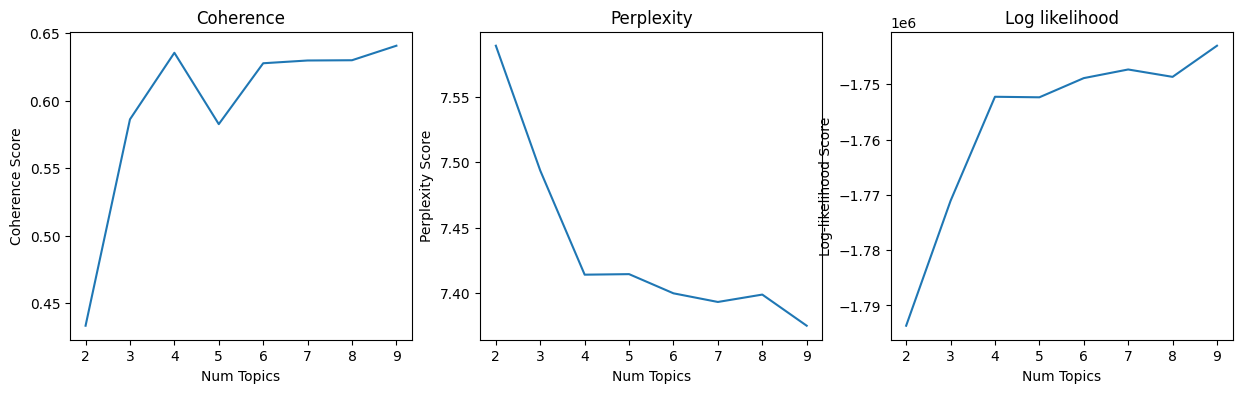

In [64]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

axs[2].plot(x, log_likelihood_scores)
axs[2].set_title('Log likelihood')
axs[2].set_xlabel('Num Topics')
axs[2].set_ylabel('Log-likelihood Score')

### Model 2. LDA with Gensim

In [65]:
# Create document-term matrix
def create_document_term_matrix(dataframe, column_name):
  cv = CountVectorizer(analyzer = 'word')
  data = cv.fit_transform(dataframe[column_name])
  df_dtm = pd.DataFrame(data.toarray(), columns = cv.get_feature_names_out())
  df_dtm.index = dataframe.index
  return df_dtm

df_dtm = create_document_term_matrix(df, 'text')

# Create bigrams and trigrams (note: only one of these will be used for modelling)
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

bigram = gensim.models.Phrases(words, min_count = 5, threshold = 100)
trigram = gensim.models.Phrases(bigram[words], threshold = 100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def make_bigrams(texts):
  return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
  return [trigram_mod[bigram_mod[doc]] for doc in texts]

words_bigrams = make_bigrams(words)
words_trigrams = make_trigrams(words)

In [66]:
# id2word dictionary and corpus
id2word = corpora.Dictionary(words)

# OPTIONAL STEP!.
# Filter out tokens that appear in less than 15 documents, more than 0.5 documents (fraction of total corpus size, not absolute number) and keep only the first 100000 most frequent tokens.
# id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

texts = words
corpus = [id2word.doc2bow(text) for text in texts]
vocab = vectorizer.get_feature_names_out()

In [67]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics, 
#                                        chunksize = 1000,
                                       passes = 100,
                                       iterations = 100,
                                       per_word_topics = True
                                      )

In [68]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.017*"game" + 0.011*"player" + 0.010*"time" + 0.009*"good" + 0.008*"last" '
  '+ 0.008*"club" + 0.007*"team" + 0.007*"first" + 0.007*"world" + '
  '0.006*"second"'),
 (1,
  '0.012*"technolog" + 0.011*"phone" + 0.010*"mobil" + 0.010*"servic" + '
  '0.008*"user" + 0.008*"comput" + 0.007*"firm" + 0.007*"network" + '
  '0.007*"softwar" + 0.006*"net"'),
 (2,
  '0.027*"film" + 0.018*"good" + 0.015*"music" + 0.012*"award" + 0.011*"game" '
  '+ 0.010*"year" + 0.006*"actor" + 0.006*"number" + 0.006*"show" + '
  '0.006*"song"'),
 (3,
  '0.012*"compani" + 0.011*"market" + 0.009*"firm" + 0.009*"sale" + '
  '0.008*"price" + 0.007*"growth" + 0.007*"economi" + 0.007*"share" + '
  '0.007*"rate" + 0.007*"m"'),
 (4,
  '0.014*"govern" + 0.011*"elect" + 0.009*"labour" + 0.007*"parti" + '
  '0.007*"public" + 0.007*"tori" + 0.007*"plan" + 0.006*"minist" + 0.006*"law" '
  '+ 0.005*"campaign"')]


In [69]:
# Sample code for model "accuracy" check

new_words = [nltk.word_tokenize(sentence) for sentence in df['text']]
new_doc_dict = corpora.Dictionary(new_words)
new_doc_bow = [new_doc_dict.doc2bow(doc) for doc in new_words]
new_doc_topics = [lda_model.get_document_topics(doc) for doc in new_doc_bow]

preds = []
for i in new_doc_topics:
  cur_pred = [-1, -1]
  for prediction in i:
    if prediction[1] > cur_pred[1]:
      cur_pred[0] = prediction[0]
      cur_pred[1] = prediction[1]
  preds.append(cur_pred[0])
  
  
topic_vocab = {0: 'entertainment', 1: 'tech', 2: 'business', 3: 'politics', 4: 'sport'}

preds = [topic_vocab[num_topic] for num_topic in preds]
df['preds'] = preds

counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1
    
print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.169438202247191


In [70]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.090035 -0.061087       1        1  24.372516
1      0.055118  0.166274       2        1  21.982013
3      0.156881 -0.021595       3        1  21.125097
0     -0.096421 -0.159942       4        1  18.302064
2     -0.205613  0.076351       5        1  14.218310, topic_info=          Term         Freq        Total Category  logprob  loglift
30        film   950.000000   950.000000  Default  30.0000  30.0000
860       game  1392.000000  1392.000000  Default  29.0000  29.0000
58       music   858.000000   858.000000  Default  28.0000  28.0000
127     govern  1112.000000  1112.000000  Default  27.0000  27.0000
686  technolog   638.000000   638.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
85        time   161.849560  1313.298030   Topic5  -5.3780  -0.1430
371      first   149.572521   835.365766   Topic5  -5.4568   0.2306
274      world   138.553486   888.543146   Topic5  -5.5334   0.0923
791        day   133.257414   638.163398   Topic5  -5.5723   0.3843
12         big   133.486791   706.409816   Topic5  -5.5706   0.2844

[360 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
4580      5  0.996953     actor
5461      5  0.992666   actress
222       3  0.960085  aircraft
223       3  0.993744    airlin
3299      2  0.024735     album
...     ...       ...       ...
392       3  0.236081      year
392       4  0.197024      year
392       5  0.289026      year
356       3  0.988717       yen
219       3  0.977715      yuko

[710 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 1, 3])

In [71]:
# Calculate perplexity
perplexity = lda_model.log_perplexity(corpus)
perplexity

-7.603563776884092

In [72]:
# Model evaluation with Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = words, dictionary = id2word, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()

print(coherence_lda)

0.5765333923288474


In [73]:
def compute_coherence_values(id2word, corpus, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           id2word=id2word, 
                                           num_topics=num_topics,
                                       passes = 100,
                                       iterations = 100,
                                       per_word_topics = True,
#                                        alpha = 1,
#                                        eta = 0.8
                                      )
        model_list.append(model)
        
#         topics = []
#         for i in range(model.num_topics):
#             topic_words = [vocab[j] for j in model.get_topics()[i].argsort()[:-10 - 1:-1]]
#             topics.append(topic_words)
        
        
        coherencemodel = CoherenceModel(model=model, texts=words, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = model.log_perplexity(corpus)
        perplexity_list.append(perplexity)
        
    return model_list, coherence_values, perplexity_list
  
model_list, coherence_values, perplexity_list = compute_coherence_values(id2word=id2word, corpus=corpus, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Perplexity Score')

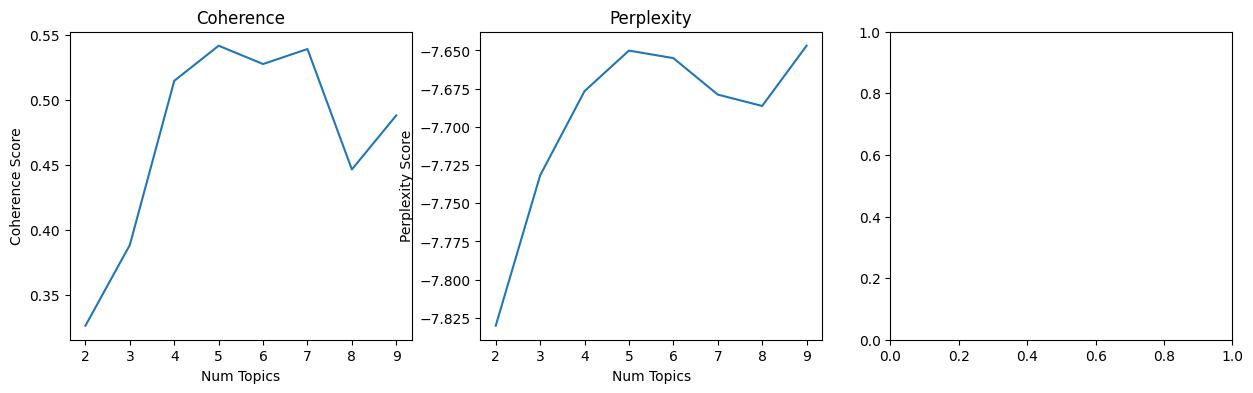

In [74]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

# axs[2].plot(x, log_likelihood_scores)
# axs[2].set_title('Log likelihood')
# axs[2].set_xlabel('Num Topics')
# axs[2].set_ylabel('Log-likelihood Score')

In [75]:
best_num = 5

# Select the model and print the topics
optimal_model = model_list[best_num-2]
model_topics = optimal_model.show_topics(formatted=False)
optimal_model.print_topics(num_words=10)

[(0,
  '0.014*"govern" + 0.012*"elect" + 0.010*"labour" + 0.008*"parti" + 0.008*"public" + 0.007*"tori" + 0.007*"plan" + 0.006*"minist" + 0.006*"campaign" + 0.006*"issu"'),
 (1,
  '0.011*"secur" + 0.010*"site" + 0.009*"softwar" + 0.009*"law" + 0.008*"firm" + 0.008*"email" + 0.008*"user" + 0.008*"court" + 0.007*"system" + 0.007*"attack"'),
 (2,
  '0.011*"compani" + 0.011*"market" + 0.009*"firm" + 0.008*"sale" + 0.008*"price" + 0.008*"economi" + 0.008*"growth" + 0.007*"rate" + 0.007*"share" + 0.006*"month"'),
 (3,
  '0.016*"good" + 0.013*"film" + 0.012*"game" + 0.008*"last" + 0.008*"time" + 0.008*"year" + 0.008*"player" + 0.007*"award" + 0.007*"first" + 0.006*"world"'),
 (4,
  '0.015*"music" + 0.012*"game" + 0.011*"technolog" + 0.011*"phone" + 0.010*"mobil" + 0.008*"servic" + 0.006*"tv" + 0.006*"digit" + 0.006*"video" + 0.006*"network"')]

In [76]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.215959 -0.053747       1        1  25.566839
4     -0.009923 -0.096146       2        1  21.994075
0      0.000360  0.069029       3        1  21.663686
2     -0.035654  0.180883       4        1  20.750062
1     -0.170742 -0.100019       5        1  10.025337, topic_info=          Term         Freq        Total Category  logprob  loglift
58       music   870.000000   870.000000  Default  30.0000  30.0000
860       game  1413.000000  1413.000000  Default  29.0000  29.0000
364      elect   656.000000   656.000000  Default  28.0000  28.0000
30        film   975.000000   975.000000  Default  27.0000  27.0000
822      phone   573.000000   573.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
1901      bill    85.245031   232.391477   Topic5  -5.6697   1.2972
46    internet    88.199564   282.573893   Topic5  -5.6356   1.1357
813     messag    83.930282   218.176565   Topic5  -5.6852   1.3447
167     action    89.820633   349.307531   Topic5  -5.6174   0.9419
78      servic    93.630874   806.215038   Topic5  -5.5758   0.1471

[372 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2919      4  0.960069    10bn
167       1  0.231887  action
167       2  0.105924  action
167       3  0.300595  action
167       4  0.108787  action
...     ...       ...     ...
392       1  0.415655    year
392       2  0.148018    year
392       3  0.162648    year
392       4  0.243541    year
392       5  0.030120    year

[766 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 1, 3, 2])

### Model 2.1 LDA with Gensim model with TF-IDF (alternative approach)

In [80]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

In [81]:
# LDA model
num_topics = 5

lda_model = gensim.models.LdaMulticore(corpus = corpus_tfidf, id2word = id2word, num_topics = num_topics, 
                                       chunksize = 1000,
                                       passes = 100,
                                       iterations = 100,
                                       per_word_topics = True
                                      )

In [82]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.008*"game" + 0.004*"film" + 0.004*"club" + 0.004*"sale" + '
  '0.003*"kilroysilk" + 0.003*"student" + 0.002*"book" + 0.002*"market" + '
  '0.002*"nadal" + 0.002*"vehicl"'),
 (1,
  '0.007*"film" + 0.006*"good" + 0.006*"award" + 0.005*"game" + 0.004*"music" '
  '+ 0.004*"player" + 0.003*"actor" + 0.003*"match" + 0.003*"band" + '
  '0.003*"win"'),
 (2,
  '0.005*"law" + 0.004*"polic" + 0.004*"govern" + 0.003*"case" + '
  '0.003*"attack" + 0.003*"court" + 0.003*"spam" + 0.003*"trial" + '
  '0.003*"legal" + 0.003*"terror"'),
 (3,
  '0.009*"mobil" + 0.009*"phone" + 0.008*"technolog" + 0.006*"user" + '
  '0.006*"music" + 0.005*"comput" + 0.005*"softwar" + 0.005*"network" + '
  '0.005*"servic" + 0.005*"digit"'),
 (4,
  '0.006*"elect" + 0.005*"govern" + 0.005*"labour" + 0.005*"tax" + '
  '0.005*"economi" + 0.004*"econom" + 0.004*"rate" + 0.004*"tori" + '
  '0.004*"growth" + 0.004*"oil"')]


In [83]:
# Do preprocessing with tokenization one more time
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
dictionary = corpora.Dictionary(words)
corpus = [dictionary.doc2bow(doc) for doc in words]

tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus_tfidf = tfidf[corpus]

# Make predictions
doc_topics = [lda_model.get_document_topics(doc) for doc in corpus_tfidf]

# Calculate the model's "accuracy"
preds = []
for i in doc_topics:
  cur_pred = [-1, -1]
  for prediction in i:
    if prediction[1] > cur_pred[1]:
      cur_pred[0] = prediction[0]
      cur_pred[1] = prediction[1]
  preds.append(cur_pred[0])
  
topic_vocab = {0: 'tech', 1: 'entertainment', 2: 'politics', 3: 'business', 4: 'sport'}

preds = [topic_vocab[num_topic] for num_topic in preds]
df['preds'] = preds

counter = 0

for i in range(len(df)):
  if df['labels'][i] == df['preds'][i]:
    counter += 1
    
print(f'Supposed model accuracy: {counter / len(df)}')

Supposed model accuracy: 0.19370786516853933


In [84]:
# Print the most common words per topic
pprint(lda_model.print_topics())

[(0,
  '0.008*"game" + 0.004*"film" + 0.004*"club" + 0.004*"sale" + '
  '0.003*"kilroysilk" + 0.003*"student" + 0.002*"book" + 0.002*"market" + '
  '0.002*"nadal" + 0.002*"vehicl"'),
 (1,
  '0.007*"film" + 0.006*"good" + 0.006*"award" + 0.005*"game" + 0.004*"music" '
  '+ 0.004*"player" + 0.003*"actor" + 0.003*"match" + 0.003*"band" + '
  '0.003*"win"'),
 (2,
  '0.005*"law" + 0.004*"polic" + 0.004*"govern" + 0.003*"case" + '
  '0.003*"attack" + 0.003*"court" + 0.003*"spam" + 0.003*"trial" + '
  '0.003*"legal" + 0.003*"terror"'),
 (3,
  '0.009*"mobil" + 0.009*"phone" + 0.008*"technolog" + 0.006*"user" + '
  '0.006*"music" + 0.005*"comput" + 0.005*"softwar" + 0.005*"network" + '
  '0.005*"servic" + 0.005*"digit"'),
 (4,
  '0.006*"elect" + 0.005*"govern" + 0.005*"labour" + 0.005*"tax" + '
  '0.005*"economi" + 0.004*"econom" + 0.004*"rate" + 0.004*"tori" + '
  '0.004*"growth" + 0.004*"oil"')]


In [85]:
# Model results evaluation + model visualization html file

pyLDAvis.enable_notebook()
model_filepath = 'LDA_Model_' + str(num_topics)

LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, id2word)
with open(model_filepath, 'wb') as f:
  pickle.dump(LDAvis_prepared, f)
  
with open(model_filepath, 'rb') as f:
  LDAvis_prepared = pickle.load(f)
  
pyLDAvis.save_html(LDAvis_prepared, 'LDAvis_prepared_' + str(num_topics) + '.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.142445  0.063481       1        1  26.756806
1      0.249657  0.065829       2        1  23.476822
3     -0.019152 -0.253233       3        1  21.647940
2     -0.131302  0.100838       4        1  16.439581
0      0.043242  0.023085       5        1  11.678851, topic_info=           Term         Freq        Total Category  logprob  loglift
772       mobil  2403.000000  2403.000000  Default  30.0000  30.0000
822       phone  2345.000000  2345.000000  Default  29.0000  29.0000
686   technolog  2135.000000  2135.000000  Default  28.0000  28.0000
89         user  1651.000000  1651.000000  Default  27.0000  27.0000
4283      award  1725.000000  1725.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
52            m   265.232999  1863.085293   Topic5  -6.3203   0.1980
85         time   260.247024  1915.598155   Topic5  -6.3393   0.1512
731       futur   236.207504  1082.108460   Topic5  -6.4362   0.6254
118    european   229.225317   963.109991   Topic5  -6.4662   0.7119
5450       movi   228.385398   919.232429   Topic5  -6.4699   0.7549

[366 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2919      1  0.992085     10bn
4580      2  0.955327    actor
4580      3  0.000955    actor
4580      5  0.042990    actor
5461      2  0.997932  actress
...     ...       ...      ...
391       3  0.057579   worker
391       4  0.012955   worker
391       5  0.012955   worker
218       1  0.993612  yugansk
219       1  0.997521     yuko

[801 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

In [86]:
tfidf = TfidfModel(corpus=corpus, id2word = id2word, normalize = False)
corpus = tfidf[corpus]
words = [nltk.word_tokenize(sentence) for sentence in df['text']]

def compute_coherence_values(id2word, corpus, words, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    perplexity_list = []
    
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics, 
                                       passes = 100,
                                       iterations = 100,
                                       per_word_topics = True
                                      )
        model_list.append(model)
        
#         topics = []
#         for i in range(model.num_topics):
#             topic_words = [vocab[j] for j in model.get_topics()[i].argsort()[:-10 - 1:-1]]
#             topics.append(topic_words)
        
        
        coherencemodel = CoherenceModel(model=model, texts=words, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
        perplexity = model.log_perplexity(corpus)
        perplexity_list.append(perplexity)
        
    return model_list, coherence_values, perplexity_list
  
model_list, coherence_values, perplexity_list = compute_coherence_values(id2word=id2word, corpus=corpus, words=words, start=2, limit=10, step=1)

Text(0, 0.5, 'Perplexity Score')

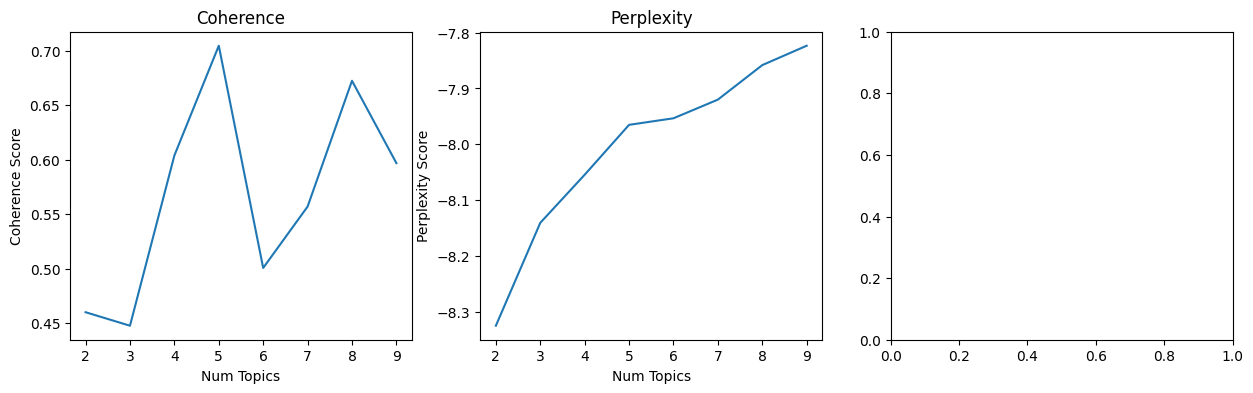

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, perplexity_list)
axs[1].set_title('Perplexity')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Perplexity Score')

# axs[2].plot(x, log_likelihood_scores)
# axs[2].set_title('Log likelihood')
# axs[2].set_xlabel('Num Topics')
# axs[2].set_ylabel('Log-likelihood Score')

### Model 3. BERTopic

In [83]:

# OPTIONAL CODE! MODEL COMPONENTS EXAMPLES
# ----------------------------------------------------------------------------------------

# embedding_model_1 = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')
# embedding_model_2 = SentenceTransformer('allenai-specter')
# umap_model_1 = PCA(n_components = 5)
# umap_model_2 = UMAP(n_neighbors = 15, n_components = 5, min_dist = 0.0, metric = 'cosine', random_state = 100)
# cluster_model_1 = KMeans(n_clusters = 50)
# cluster_model_2 = HDBSCAN(min_cluster_size=80, min_samples=40, metric = 'euclidean', gen_min_span_tree=True, prediction_data=True)
# vectorizer_model_1 = CountVectorizer(ngram_range = (1,3), stop_words = 'english')
# ctfidf_model_1 = ClassTfidfTransformer(bm25_weighting = True)



# topic_model = BERTopic(
#   umap_model = (umap_model_1, umap_model_2),
#                        embedding_model = (embedding_model_1, embedding_model_2),
#                        hdbscan_model = (cluster_model_1, cluster_model_2),
#                        vectorizer_model = (vectorizer_model_1),
#                        ctfidf_model = (ctfidf_model_1),
#                        calculate_probabilities = True,
#                        verbose = True,
#                        language = 'english')

# ----------------------------------------------------------------------------------------




# OPTIONAL CODE! PICKING THE BESE SENTENCE ENCODER MODEL
# ----------------------------------------------------------------------------------------

# Model initialization, hyperparameters and fitting
# models_list = ['all-mpnet-base-v2', 
#                'multi-qa-mpnet-base-dot-v1',
#                'all-distilroberta-v1',
#                'all-MiniLM-L12-v2',
#                'multi-qa-distilbert-cos-v1',
#                'all-MiniLM-L6-v2',
#                'multi-qa-MiniLM-L6-cos-v1',
#                'paraphrase-multilingual-mpnet-base-v2',
#                'paraphrase-albert-small-v2',
#                'paraphrase-multilingual-MiniLM-L12-v2',
#                'paraphrase-MiniLM-L3-v2',
#                'distiluse-base-multilingual-cased-v2']
# df_list = []
# topics_list = []
# probs_list = []

# for embedding_model in models_list:
#   topic_model = BERTopic(embedding_model = embedding_model, calculate_probabilities = True, n_gram_range = (1,2))
#   topics, probs = topic_model.fit_transform(df['text'])
#   topic_model.reduce_topics(df['text'], nr_topics = 6)
#   df_list.append(topic_model.get_topic_info())
  
#   print(f'Model: {embedding_model}')
#   print(topic_model.get_topic_info())
#   print('\n')
#   print('\n')

# ----------------------------------------------------------------------------------------




# OPTIONAL CODE! UMAP HYPERPARAMETER TUNING
# ----------------------------------------------------------------------------------------
# nn_list = [15]
# n_comp_list = [5]
# metrics = ['cosine', 'euclidean']
# min_dist_list = [0.2, 0.3, 0.4, 0.5]

# results_list = []

# for n_neighbors in nn_list:
#   for n_components in n_comp_list:
#     for metric in metrics:
#       for min_dist in min_dist_list:
#         umap_model = UMAP(n_neighbors = n_neighbors, n_components = n_components, metric = metric, min_dist = min_dist)

#         topic_model = BERTopic(embedding_model = 'multi-qa-distilbert-cos-v1', calculate_probabilities = True, umap_model = umap_model)
#         topics, probs = topic_model.fit_transform(df['text'])
#         topic_model.reduce_topics(df['text'], nr_topics = 6)

#         print(f'n_neighbors: {n_neighbors}, n_components: {n_components}, metric: {metric}, min_dist: {min_dist}')
#         print(topic_model.get_topic_info())
#         print('\n')

#         results_list.append(([n_neighbors, n_components, metric], topic_model.get_topic_info()))
# ----------------------------------------------------------------------------------------





# OPTIONAL CODE! HDBSCAN HYPERPARAMETER TUNING
# ----------------------------------------------------------------------------------------

# cluster_model = HDBSCAN(min_cluster_size=80, min_samples=40, metric = 'euclidean', gen_min_span_tree=True, prediction_data=True)


# min_cluster_size_list = [10, 20, 30, 40, 50, 60, 70, 80]
# min_samples_list = [1, 3, 5, 10, 20, 40]
# cluster_selection_epsilon_list = [0.1, 0.2, 0.4, 0.6, 0.8, 0.9]
# alpha_list = [0.1, 0.3, 0.5, 0.8, 1, 1.3, 1.5, 1.8, 2, 2.5]
# metric_list = ['euclidean', 'manhattan']

# results_list = []

# for alpha in alpha_list:
  
#       hdbscan_model = HDBSCAN(alpha = alpha, prediction_data=True)

#       topic_model = BERTopic(calculate_probabilities = True, hdbscan_model = hdbscan_model)
#       topics, probs = topic_model.fit_transform(df['text'])
#       topic_model.reduce_topics(df['text'], nr_topics = 6)

#       print(f'alpha: {alpha}')
#       print(topic_model.get_topic_info())
#       print('\n')

#       results_list.append(([min_cluster_size, min_samples, metric], topic_model.get_topic_info()))
      
# ----------------------------------------------------------------------------------------



# # OPTIONAL CODE! SOME CLUSTERING ALGORITHMS TO CONSIDER
# ----------------------------------------------------------------------------------------

# hdbscan_model_list = [
#   AgglomerativeClustering(n_clusters = 5),
#   SpectralClustering(n_clusters = 5, assign_labels = 'discretize'),
#   Birch(n_clusters = 5),
#   KMeans(n_clusters = 5)
# ]

# ----------------------------------------------------------------------------------------

### Model 3.1 BERTopic with KMeans clusterring

In [88]:
# Custom clustring algorithm
hdbscan_model = KMeans(n_clusters = 5)

# BERTopic model
topic_model = BERTopic(calculate_probabilities = True, hdbscan_model = hdbscan_model, language = 'english', n_gram_range = (1,2))
topics, probs = topic_model.fit_transform(df['text'])
print(topic_model.get_topic_info())

   Topic  Count                          Name
0      0    524       0_game_player_club_good
1      1    488    1_compani_market_firm_sale
2      2    457    2_govern_elect_labour_tori
3      3    381       3_film_music_good_award
4      4    375  4_game_mobil_phone_technolog


In [89]:
# Define topic vocabulary
topic_vocab = {0: 'sport', 1: 'business', 2: 'politics', 3: 'entertainment', 4: 'tech'}

In [90]:
# Reformat predicted values
topics = [topic_vocab[topic] for topic in topics]

# Topic assignment for the training set
assigned_topics_df = pd.DataFrame({'topic':topics, 'document': df['text'], 'labels': df['labels']})

# Calculate model accuracy*
acc = sum(assigned_topics_df['topic'] == assigned_topics_df['labels']) / len(df)
print(f'Model "Accuracy": {acc}')

Model "Accuracy": 0.9226966292134832


In [91]:
# Model prediction example on new data
topic_distribution = topic_model.transform(df['text'])
print(f"Topic distribution: {topic_distribution[0][:5]}")

Topic distribution: [1, 1, 1, 1, 1]


In [92]:
# Most common words for a particular topic
topic_number = 1
topic_model.get_topic(topic_number)

[('compani', 0.02512465129240945),
 ('market', 0.024385839139636437),
 ('firm', 0.0229801004657039),
 ('sale', 0.020427399118438255),
 ('growth', 0.020359725123572914),
 ('economi', 0.019581385604625752),
 ('price', 0.019581338737464173),
 ('share', 0.017450446044035797),
 ('rate', 0.01687420488519395),
 ('econom', 0.016342126181301424)]

In [93]:
# Documents that represent a particular topic the most
topic_number = 1
topic_model.get_representative_docs(topic_number)

['interest rate bank interest rate move rate time bank cool hous market consum debt unchang recent datum slowdown consum spend mortgag approv retail sale analyst drop less consum confid interest rate slowdown hous market consum optim sharp fall demand expens good report earli week brc retail bad decad today decis correct director gener clear sign economi readi quick correct action cut rate dismal report trade sale gener weaken consum spend frost hous market outlook uncertain hous price risk economi economist ian mccafferti economi recent month respons rate difficult gaug period like pace activ summer emerg inflationari pressur tight labour market buoyant commod price overabrupt slowdown consum activ interest rate hold time gloomi news manufactur front offic nation on statist british output fifth month on manufactur output novemb similar unrevis fall economist expect rise interest rate futur evid manufactur confid outlook world economi uncertain far evid last year rate increas economi r

In [94]:
# Most common words per topic barchart visualization
topic_model.visualize_barchart(top_n_topics = 8)

In [95]:
# Intertopic distance map and topic relations
topic_model.visualize_topics()

In [96]:
# Topic heatmap that represents how much different topics overlap
topic_model.visualize_heatmap()

In [97]:
# Hierarchical clustering per topic and related similarities
topic_model.visualize_hierarchy()

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:350: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:351: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:352: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead

C:\Users\User\anaconda3\envs\newtensorflow\lib\site-packages\plotly\figure_factory\_dendrogram.py:353: DeprecationWarning:

scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead



In [98]:
# # Topic probability distribution - WORKS FOR PROBABILISTC CLUSTERING MODELS ONLY (SUCH AS HDBSCAN)
# doc_number = 0
# topic_model.visualize_distribution(probs[doc_number])

In [99]:
# New document classification, most similar topics and the corresponding most common words
new_doc = 'This is my new document about sport'

num_of_topics = 3
similar_topics, similarity = topic_model.find_topics(new_doc, top_n = num_of_topics)

print(f'The top {num_of_topics} similar topics are {similar_topics}, and the similarities are {np.round(similarity, 2)}')

for i in range(num_of_topics):
  print(f'The top keywords for topic {similar_topics[i]} are:')
  print(topic_model.get_topic(similar_topics[i]))

The top 3 similar topics are [0, 3, 1], and the similarities are [0.31 0.23 0.22]
The top keywords for topic 0 are:
[('game', 0.02984540933298471), ('player', 0.026139790518340998), ('club', 0.0230723035427614), ('good', 0.020397220102426693), ('time', 0.019563397732396782), ('team', 0.019268015562844878), ('last', 0.019104632940266774), ('side', 0.018283227183910015), ('match', 0.017966755295744343), ('second', 0.016529061348334474)]
The top keywords for topic 3 are:
[('film', 0.05466991358741684), ('music', 0.0397315788869442), ('good', 0.03389465656754009), ('award', 0.027720580177554455), ('song', 0.019149552366295706), ('actor', 0.018899433780609945), ('year', 0.018172875861681332), ('band', 0.01693225424347022), ('show', 0.015335566039170977), ('star', 0.015167519839631754)]
The top keywords for topic 1 are:
[('compani', 0.02512465129240945), ('market', 0.024385839139636437), ('firm', 0.0229801004657039), ('sale', 0.020427399118438255), ('growth', 0.020359725123572914), ('economi

In [100]:
# Topic similarities
similar_topics, similarity = topic_model.find_topics('tennis', top_n = 3)

for sim_topic in similar_topics:
  print(sim_topic)
  print(topic_model.get_topic(sim_topic))

0
[('game', 0.02984540933298471), ('player', 0.026139790518340998), ('club', 0.0230723035427614), ('good', 0.020397220102426693), ('time', 0.019563397732396782), ('team', 0.019268015562844878), ('last', 0.019104632940266774), ('side', 0.018283227183910015), ('match', 0.017966755295744343), ('second', 0.016529061348334474)]
3
[('film', 0.05466991358741684), ('music', 0.0397315788869442), ('good', 0.03389465656754009), ('award', 0.027720580177554455), ('song', 0.019149552366295706), ('actor', 0.018899433780609945), ('year', 0.018172875861681332), ('band', 0.01693225424347022), ('show', 0.015335566039170977), ('star', 0.015167519839631754)]
4
[('game', 0.024177652348968764), ('mobil', 0.023344441636714158), ('phone', 0.022904851262717473), ('technolog', 0.02282471590235592), ('user', 0.019689405043178277), ('servic', 0.018879954620170183), ('comput', 0.018205317061451367), ('softwar', 0.01649738159495005), ('system', 0.015170583222346382), ('net', 0.015145861106737905)]


In [104]:
# Topic labelling formatting and custom labels
topic_labels = topic_model.generate_topic_labels(nr_words = 3, 
                                                 topic_prefix = False,
                                                 word_length = 15,
                                                 separator = ' - ')
topic_model.set_topic_labels(topic_labels)
topic_model.set_topic_labels({0: 'sport', 1: 'business', 2: 'politics', 3: 'entertainment', 4: 'tech'})
topic_model.get_topic_info().head(10)

Topic  Count                          Name     CustomName
0      0    524       0_game_player_club_good          sport
1      1    488    1_compani_market_firm_sale       business
2      2    457    2_govern_elect_labour_tori       politics
3      3    381       3_film_music_good_award  entertainment
4      4    375  4_game_mobil_phone_technolog           tech

In [105]:
# # EXTRA METHODS

# # Change n-grams without re-fitting our entire model
# topic_model.update_topics(df['text'], n_gram_range=(1,3))

# # Merge specific topics
# topic_model.merge_topics(df['text'], topics_to_merge = [1, 8, 12])

# # Reduce the number of topics by iteratively merging them
# topic_model.reduce_topics(df['text'], nr_topics = 5)

In [106]:
# Document clusters visualization per topic - COMPUTATIONALLY EXPENSIVE
topic_model.visualize_documents(df['text'],
                               topics = list(range(10)),
                               custom_labels = True,
                               height = 600)

### Model 4 Nonnegative Matrix Factorization (NMF) With TF-IDF vectorizer

In [231]:
tfidf = TfidfVectorizer(stop_words = stops,
#                              max_df = 0.95, 
#                              min_df = 2,
#                              max_features = 1000,
#                              lowercase = False, 
#                              ngram_range = (1,3),
                            )
dtm = tfidf.fit_transform(df['text'])

In [232]:
nmf = NMF(n_components = 5,
          beta_loss = 'kullback-leibler', # you should use this loss with the "mu" solver
          solver = 'mu',
          alpha_W = 0.1,
          alpha_H = 0.1,
          # l1_ratio = 0.5,
          # random_state = 0,
          init='nndsvda',
          # beta_loss="frobenius",
          max_iter = 500
         )

nmf.fit(dtm)

NMF(alpha_H=0.1, alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',
    max_iter=500, n_components=5, solver='mu')

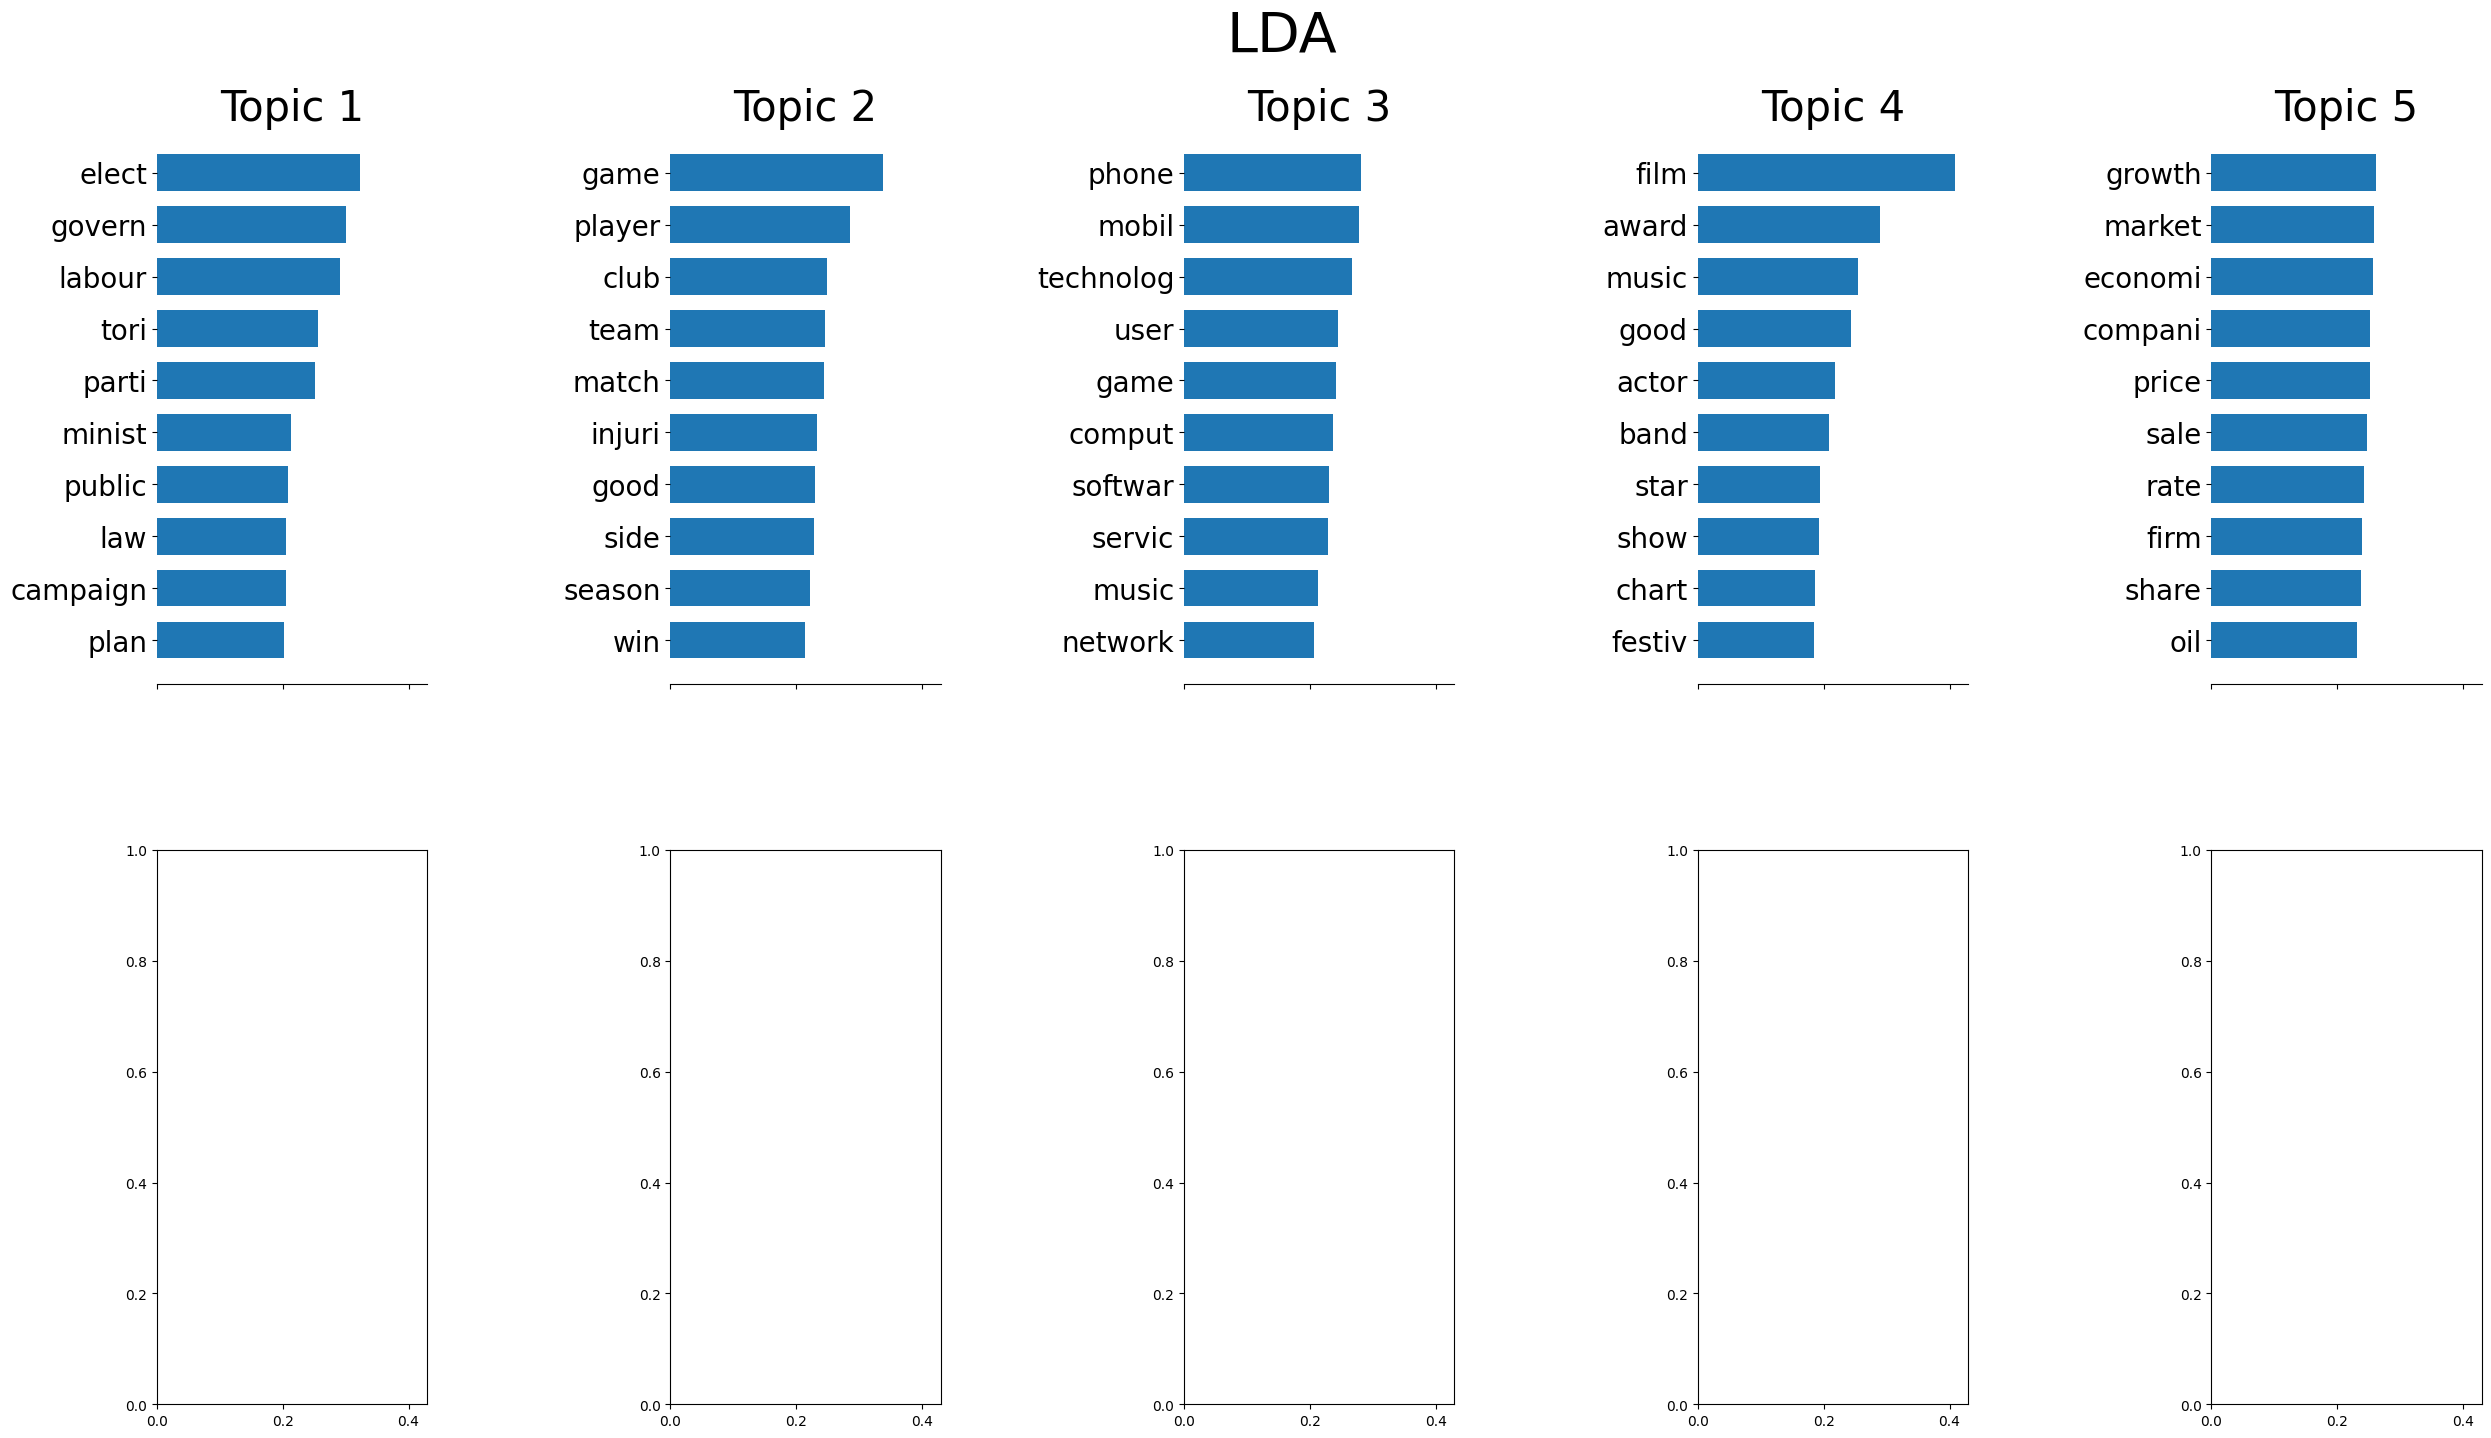

In [233]:
feature_names = tfidf.get_feature_names_out()
plot_top_words(nmf, feature_names)

Text(0.5, 1.0, 'True label: sport')

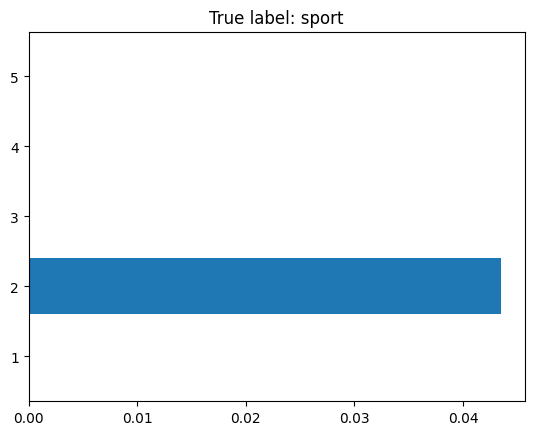

In [234]:
Z = nmf.transform(dtm)

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(5) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title(f'True label: {df.iloc[i]["labels"]}')

In [235]:
def wrap(x):
  return textwrap.fill(x, replace_whitespace = False, fix_sentence_endings = True)

print(wrap(df.iloc[i]['text']))

fit bid flanker unlik part wale final game nation wale victori ankl
injuri recoveri figur game unlik readi final game wale physio mark
davi sonni parker struggl neck injuri luscomb fit slim chanc scot
march luscomb fit match hamstr troubl wale assist coach rare go mix
depth option replac hooker knee ligament damag last know end week
robin earli stage dragon mcbryde recov


In [236]:
for index, topic in enumerate(nmf.components_):
  print(f'THE TOP 15 WORDS FOR TOPIC # {index}')
  word_list = [tfidf.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
  word_list.reverse()
  print(word_list)
  print('\n')

THE TOP 15 WORDS FOR TOPIC # 0
['elect', 'govern', 'labour', 'tori', 'parti', 'minist', 'public', 'law', 'campaign', 'plan', 'polit', 'tax', 'leader', 'issu', 'conserv']


THE TOP 15 WORDS FOR TOPIC # 1
['game', 'player', 'club', 'team', 'match', 'injuri', 'good', 'side', 'season', 'win', 'final', 'champion', 'last', 'time', 'second']


THE TOP 15 WORDS FOR TOPIC # 2
['phone', 'mobil', 'technolog', 'user', 'game', 'comput', 'softwar', 'servic', 'music', 'network', 'site', 'digit', 'net', 'internet', 'firm']


THE TOP 15 WORDS FOR TOPIC # 3
['film', 'award', 'music', 'good', 'actor', 'band', 'star', 'show', 'chart', 'festiv', 'singer', 'album', 'oscar', 'actress', 'number']


THE TOP 15 WORDS FOR TOPIC # 4
['growth', 'market', 'economi', 'compani', 'price', 'sale', 'rate', 'firm', 'share', 'oil', 'profit', 'bank', 'econom', 'dollar', 'analyst']




In [238]:
topic_results = nmf.transform(dtm)

topic_vocab = {0: 'politics', 1: 'sport', 2: 'tech', 3: 'entertainment', 4: 'business'}

predicted_topics = topic_results.argmax(axis = 1)
predicted_topics = [topic_vocab[i] for i in predicted_topics]
df['Predicted_Topic'] = predicted_topics
print(df.head(3))
print('\n')

acc = sum(df['labels'] == df['Predicted_Topic']) / len(df)
print(f'Estimated model accuracy: {round(acc, 3)}')

                                                text    labels Predicted_Topic
0  ad sale time profit quarterli media giant time...  business        business
1  dollar gain speech high level euro month trade...  business        business
2  unit buyer loan claim owner russian oil giant ...  business        business


Estimated model accuracy: 0.921


In [59]:
W1 = nmf.fit_transform(dtm)
H1 = nmf.components_

colnames = ['Topic_' + str(topic_vocab[i]) for i in range(nmf.n_components)]
docnames = ['Doc' + str(i) for i in range(len(df.text))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns = colnames, index = docnames)
significant_topic = np.argmax(df_doc_topic.values, axis = 1)
df_doc_topic['dominant_topic'] = [topic_vocab[i] for i in significant_topic]
df_doc_topic

Topic_politics  Topic_sport  Topic_tech  Topic_entertainment  \
Doc0               0.00         0.00        0.02                 0.02   
Doc1               0.01         0.00        0.00                 0.01   
Doc2               0.02         0.00        0.00                 0.00   
Doc3               0.00         0.01        0.00                 0.01   
Doc4               0.00         0.01        0.01                 0.00   
...                 ...          ...         ...                  ...   
Doc2220            0.00         0.00        0.15                 0.00   
Doc2221            0.00         0.00        0.13                 0.00   
Doc2222            0.03         0.01        0.09                 0.00   
Doc2223            0.01         0.00        0.08                 0.00   
Doc2224            0.00         0.16        0.05                 0.00   

         Topic_business dominant_topic  
Doc0               0.10       business  
Doc1               0.15       business  
Doc2               0.09       business  
Doc3               0.12       business  
Doc4               0.06       business  
...                 ...            ...  
Doc2220            0.03           tech  
Doc2221            0.01           tech  
Doc2222            0.02           tech  
Doc2223            0.01           tech  
Doc2224            0.00          sport  

[2225 rows x 6 columns]

In [109]:
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
id2word = corpora.Dictionary(words)

def compute_coherence_values(dictionary, words, limit, start=2, step=1):
  coherence_scores = []
  reconstruction_errors = []
  
  for num_topics in range(start, limit, step):
    model = NMF(n_components = num_topics)
    model.fit(dtm)
    topics = nmf.transform(dtm)
    topic_words = []
    features = tfidf.get_feature_names_out()
    for topic in model.components_:
      topic_words.append([features[idx] for idx in topic.argsort()[:-11:-1]])
    coherence_model = CoherenceModel(topics=topic_words, texts=words, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
    reconstruction_errors.append(model.reconstruction_err_)
    
  return coherence_scores, reconstruction_errors

coherence_values, reconstruction_errors = compute_coherence_values(dictionary = id2word, words = words, start=2, limit=10, step=1)

Text(0, 0.5, 'Reconstruction error')

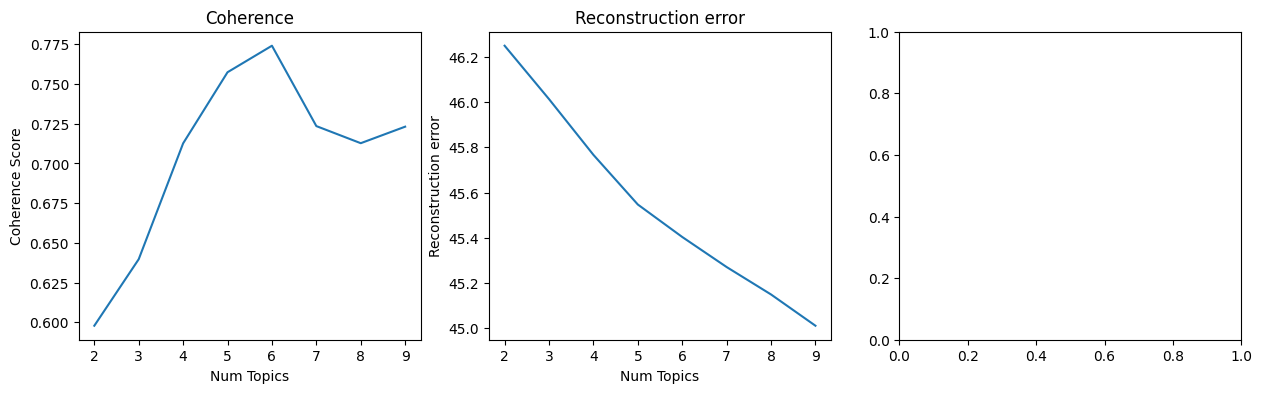

In [110]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

axs[1].plot(x, reconstruction_errors)
axs[1].set_title('Reconstruction error')
axs[1].set_xlabel('Num Topics')
axs[1].set_ylabel('Reconstruction error')

# axs[2].plot(x, log_likelihood_scores)
# axs[2].set_title('Log likelihood')
# axs[2].set_xlabel('Num Topics')
# axs[2].set_ylabel('Log-likelihood Score')

### Model 4.2 Nonnegative Matrix Factorization (NMF) With CountVectorizer

In [263]:
vectorizer = CountVectorizer(stop_words = stops,
#                              max_df = 0.95, 
#                              min_df = 2,
#                              max_features = 1000,
#                              lowercase = False, 
#                              ngram_range = (1,3),
                            )
dtm = vectorizer.fit_transform(df['text'])

In [270]:
nmf = NMF(n_components = 5,
          beta_loss = 'kullback-leibler', # you should use this loss with the "mu" solver
          solver = 'mu',
          alpha_W = 0.1,
          alpha_H = 0.1,
          # l1_ratio = 0.5,
          # random_state = 0,
          init='nndsvda',
          # beta_loss="frobenius",
          max_iter = 500
         )

nmf.fit(dtm)

NMF(alpha_H=0.1, alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',
    max_iter=500, n_components=5, solver='mu')

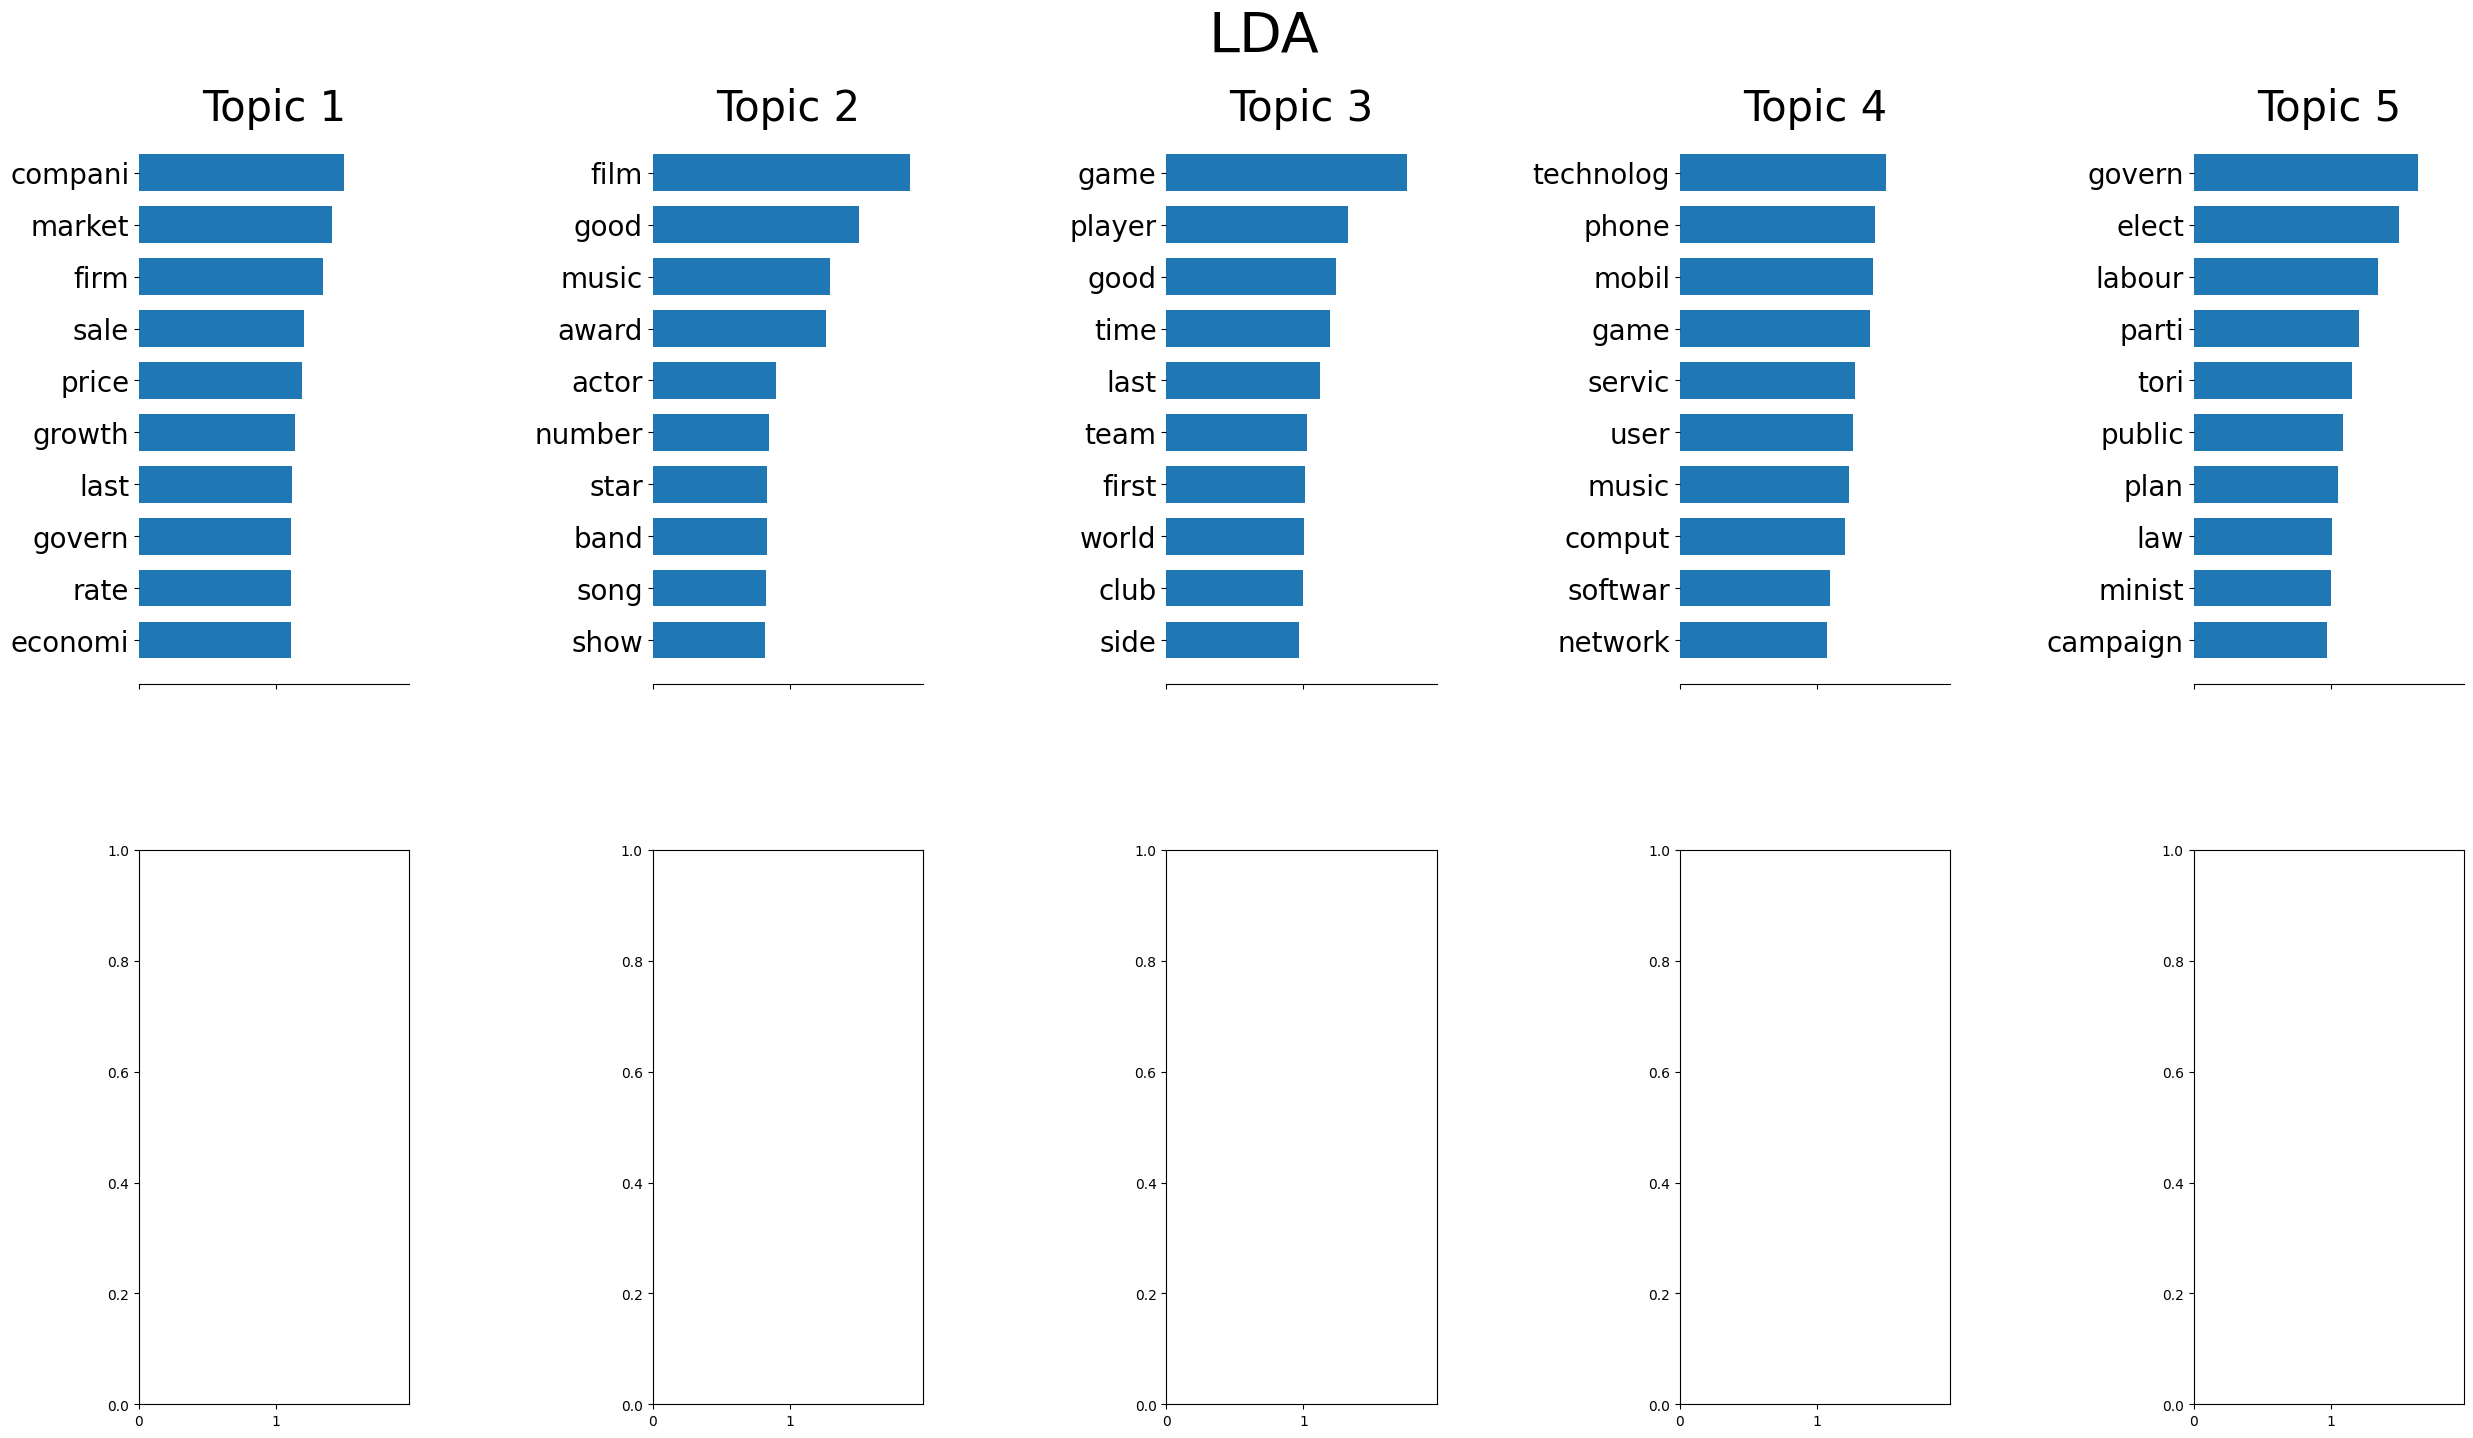

In [271]:
feature_names = vectorizer.get_feature_names_out()
plot_top_words(nmf, feature_names)

Text(0.5, 1.0, 'True label: sport')

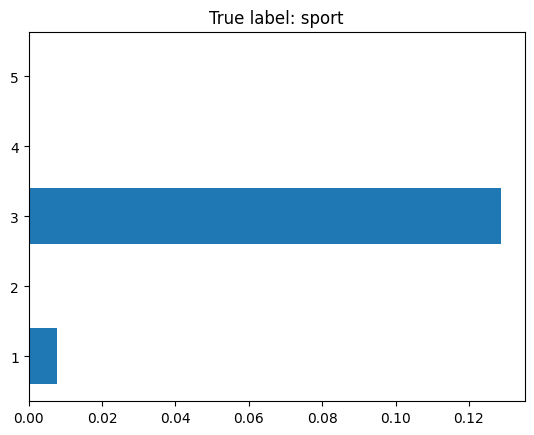

In [272]:
Z = nmf.transform(dtm)

np.random.seed(0)
i = np.random.choice(len(df))
z = Z[i]
topics = np.arange(5) + 1

fig, ax = plt.subplots()
ax.barh(topics, z)
ax.set_yticks(topics)
ax.set_title(f'True label: {df.iloc[i]["labels"]}')

In [273]:
print(wrap(df.iloc[i]['text']))

fit bid flanker unlik part wale final game nation wale victori ankl
injuri recoveri figur game unlik readi final game wale physio mark
davi sonni parker struggl neck injuri luscomb fit slim chanc scot
march luscomb fit match hamstr troubl wale assist coach rare go mix
depth option replac hooker knee ligament damag last know end week
robin earli stage dragon mcbryde recov


In [274]:
for index, topic in enumerate(nmf.components_):
  print(f'THE TOP 15 WORDS FOR TOPIC # {index}')
  word_list = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
  word_list.reverse()
  print(word_list)
  print('\n')

THE TOP 15 WORDS FOR TOPIC # 0
['compani', 'market', 'firm', 'sale', 'price', 'growth', 'last', 'govern', 'rate', 'economi', 'share', 'month', 'high', 'busi', 'econom']


THE TOP 15 WORDS FOR TOPIC # 1
['film', 'good', 'music', 'award', 'actor', 'number', 'star', 'band', 'song', 'show', 'last', 'top', 'director', 'album', 'time']


THE TOP 15 WORDS FOR TOPIC # 2
['game', 'player', 'good', 'time', 'last', 'team', 'first', 'world', 'club', 'side', 'second', 'match', 'final', 'win', 'season']


THE TOP 15 WORDS FOR TOPIC # 3
['technolog', 'phone', 'mobil', 'game', 'servic', 'user', 'music', 'comput', 'softwar', 'network', 'digit', 'net', 'system', 'site', 'firm']


THE TOP 15 WORDS FOR TOPIC # 4
['govern', 'elect', 'labour', 'parti', 'tori', 'public', 'plan', 'law', 'minist', 'campaign', 'issu', 'polit', 'leader', 'right', 'countri']




In [275]:
topic_results = nmf.transform(dtm)

topic_vocab = {0: 'business', 1: 'entertainment', 2: 'sport', 3: 'tech', 4: 'politics'}

predicted_topics = topic_results.argmax(axis = 1)
predicted_topics = [topic_vocab[i] for i in predicted_topics]
df['Predicted_Topic'] = predicted_topics
print(df.head(3))
print('\n')

acc = sum(df['labels'] == df['Predicted_Topic']) / len(df)
print(f'Estimated model accuracy: {round(acc, 3)}')

                                                text    labels Predicted_Topic
0  ad sale time profit quarterli media giant time...  business        business
1  dollar gain speech high level euro month trade...  business        business
2  unit buyer loan claim owner russian oil giant ...  business        business


Estimated model accuracy: 0.95


In [276]:
W1 = nmf.fit_transform(dtm)
H1 = nmf.components_

colnames = ['Topic_' + str(topic_vocab[i]) for i in range(nmf.n_components)]
docnames = ['Doc' + str(i) for i in range(len(df.text))]
df_doc_topic = pd.DataFrame(np.round(W1, 2), columns = colnames, index = docnames)
significant_topic = np.argmax(df_doc_topic.values, axis = 1)
df_doc_topic['dominant_topic'] = [topic_vocab[i] for i in significant_topic]
df_doc_topic

Topic_business  Topic_entertainment  Topic_sport  Topic_tech  \
Doc0               0.16                 0.02         0.00        0.09   
Doc1               0.19                 0.00         0.00        0.03   
Doc2               0.16                 0.00         0.00        0.00   
Doc3               0.21                 0.00         0.00        0.00   
Doc4               0.12                 0.08         0.00        0.00   
...                 ...                  ...          ...         ...   
Doc2220            0.06                 0.00         0.00        0.18   
Doc2221            0.03                 0.00         0.00        0.19   
Doc2222            0.11                 0.00         0.00        0.23   
Doc2223            0.06                 0.00         0.00        0.15   
Doc2224            0.11                 0.21         0.38        0.30   

         Topic_politics dominant_topic  
Doc0               0.00       business  
Doc1               0.00       business  
Doc2               0.00       business  
Doc3               0.00       business  
Doc4               0.00       business  
...                 ...            ...  
Doc2220            0.03           tech  
Doc2221            0.00           tech  
Doc2222            0.17           tech  
Doc2223            0.04           tech  
Doc2224            0.21          sport  

[2225 rows x 6 columns]

In [279]:
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
id2word = corpora.Dictionary(words)

def compute_coherence_values(dictionary, words, limit, start=2, step=1):
  coherence_scores = []
  reconstruction_errors = []
  
  for num_topics in range(start, limit, step):
    model = NMF(n_components = num_topics,
          beta_loss = 'kullback-leibler', # you should use this loss with the "mu" solver
          solver = 'mu',
          alpha_W = 0.1,
          alpha_H = 0.1,
          # l1_ratio = 0.5,
          # random_state = 0,
          init='nndsvda',
          # beta_loss="frobenius",
          max_iter = 500
         )
    
    model.fit(dtm)
    topics = nmf.transform(dtm)
    topic_words = []
    features = vectorizer.get_feature_names_out()
    for topic in model.components_:
      topic_words.append([features[idx] for idx in topic.argsort()[:-11:-1]])
    coherence_model = CoherenceModel(topics=topic_words, texts=words, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)
    
#     reconstruction_errors.append(model.reconstruction_err_)
    
  return coherence_scores

coherence_values = compute_coherence_values(dictionary = id2word, words = words, start=2, limit=10, step=1)

Text(0, 0.5, 'Coherence Score')

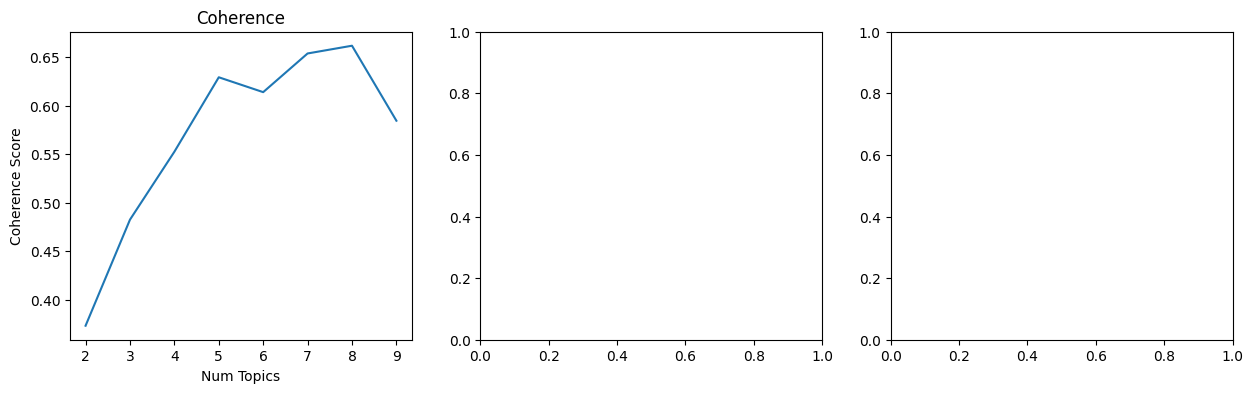

In [280]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

limit=10; start=2; step=1;
x = range(start, limit, step)

axs[0].plot(x, coherence_values)
axs[0].set_title('Coherence')
axs[0].set_xlabel('Num Topics')
axs[0].set_ylabel('Coherence Score')

# axs[1].plot(x, reconstruction_errors)
# axs[1].set_title('Reconstruction error')
# axs[1].set_xlabel('Num Topics')
# axs[1].set_ylabel('Reconstruction error')

# axs[2].plot(x, log_likelihood_scores)
# axs[2].set_title('Log likelihood')
# axs[2].set_xlabel('Num Topics')
# axs[2].set_ylabel('Log-likelihood Score')

### Model 4.4 Nonnegative Matrix Factorization (NMF) in gensim

In [286]:
words = [nltk.word_tokenize(sentence) for sentence in df['text']]
id2word = corpora.Dictionary(words)
corpus = [id2word.doc2bow(doc) for doc in words]

In [ ]:
!git add .
!git

#### Things to try to improve LDA:
* Try changing hyperparameters of LDA algorithm
* Try reducing/increasing the number of POS tags
* Try different stemmers/lemmatizers
* Try removing/leaving digits or even more radical - remove words containing numbers
* Try with/without stemming
* Try different alpha/beta parameters of LDA
* Try removing words with len < 2 or 3
* To choose the right number of topics for LDA compare the goodness of fit for various

#### LDA Parameters
* chunksize - Increasing chunksize will speed up training, at least as long as the chunk of documents easily fit into memory.
* passes/iterations - It is important to set the number of “passes” and “iterations” high enough.
* 2 Dirichlet hyperparameters: alpha and beta (or sometimes eta) - try arranging those as follows list(np.arange(0.01, 1, 0.3))  and try different params from there.
* To test different combinations of hyperparameters use nested for loops.

#### Things to try to improve BERTopic
* Try using different ngram ranges
* Reduce the number of topics
* Merge topics
* Specify the topics that you want to find using domain knowledge
* Try using topic_model.visualize_term_rank(log_scale = True/False) to determine the minimum number of words to represent a topic properly.
* It might be a good idea to do some basic preprocessing, such as removing stopwords and lemmatization/stemming
* Try hyperparameter tuning on the UMAP model
* Try hyperparameter tuning on the HDBscan model

#### BERTopic parameters
* embedding_model = 'all-miniLM-L6-v2' or 'paraphrase-MiniLM-L12-v2'. In fact, this is an important parameter that you can adjust simply by picking a model from https://sbert.net/docs/pretrained_models.html Have a look at the speed and performance of each model and adjust to your needs.
* min_topic_size - minimum number of docs per topic to create a new topic category


#### Things to try with NMF

* Try different init parameter for the sklearn NMF (such as 'nndsvda', 'nndsvd', 'random'])
* Try different beta_loss parameters (such as 'frobenius' or 'kullback-leibler')
* Try different alpha_W and alpha_H values
* Try different l1_ratio values
* Try different solver
* Try different numbers of max_iter for NMF model